In [294]:
from torch.utils.data import Dataset
import torch
import os
import pickle
import glob

In [295]:
class VRPNode():
    def __init__(self, idx, x, y, demand, a, b, s, role, pair):
        super().__init__()
        self.idx = idx
        self.x = x
        self.y = y
        self.demand = demand
        self.a = a  # earliest time
        self.b = b  # latest time
        self.s = s  # service time
        self.role = role  # role of the node (1: pickup, 0: depot, -1: delivery)
        self.pair = pair  # paired node (pickup-delivery)

class VRPInstance():
    def __init__(self, nodes, capacity, K, tmat):
        super().__init__()
        self.nodes = nodes
        self.capacity = capacity  # vehicle capacity
        self.K = K  # max number of vehicles
        self.tmat = tmat  # [n, n] travel time matrix
    
    def build_tensors(self):
        n = len(self.nodes)
        coords = torch.tensor([[node.x, node.y] for node in self.nodes], dtype=torch.float32)
        demand = torch.tensor([node.demand for node in self.nodes], dtype=torch.float32)
        tw = torch.tensor([[node.a, node.b] for node in self.nodes], dtype=torch.float32)
        service = torch.tensor([node.s for node in self.nodes], dtype=torch.float32)
        role = torch.tensor([node.role for node in self.nodes], dtype=torch.int64)
        pair = torch.tensor([node.pair for node in self.nodes], dtype=torch.int64)

        return dict(
            coords=coords,
            demand=demand,
            tw=tw,
            service=service,
            role=role,
            pair=pair,
            capacity=self.capacity,
            K=self.K,
            tmat=torch.tensor(self.tmat, dtype=torch.float32)
        )

In [296]:
def batchify(instances):
    ts = [ins.build_tensors() for ins in instances]
    batch = {k: torch.stack([t[k] for t in ts]) for k in ts[0] if k not in ['capacity', 'K']}
    batch['capacity'] = torch.tensor([ins.capacity for ins in instances], dtype=torch.float32)[:, None]
    batch['K'] = torch.tensor([ins.K for ins in instances], dtype=torch.int64)[:, None]
    return batch

In [297]:
def read_pdptw_file(filepath):
    data = {
        "metadata": {},
        "nodes": [],
        "edges": []
    }
    
    with open(filepath, 'r') as file:
        lines = file.readlines()

    section = "metadata"
    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Section switches
        if line == "NODES":
            section = "nodes"
            continue
        elif line == "EDGES":
            section = "edges"
            continue
        elif line == "EOF":
            break

        if section == "metadata":
            if ":" in line:
                key, value = line.split(":", 1)
                data["metadata"][key.strip()] = value.strip()

        elif section == "nodes":
            parts = line.split()
            if len(parts) >= 8:
                node = {
                    "id": int(parts[0]),
                    "x": float(parts[1]),
                    "y": float(parts[2]),
                    "demand": int(parts[3]),
                    "ready_time": int(parts[4]),
                    "due_time": int(parts[5]),
                    "service_time": int(parts[6]),
                    "pickup_or_delivery": 0 if (int(parts[7]) == 0 and int(parts[8]) == 0) else (-1 if int(parts[7]) > 0 else 1),  # 0 = depot, 1 = pickup, -1 = delivery,...
                    "pair_id": int(parts[7]) if int(parts[7]) > 0 else int(parts[8])
                }
                data["nodes"].append(node)

        elif section == "edges":
            weights = list(map(int, line.split()))
            data["edges"].append(weights)

    nodes = []

    for node_data in data["nodes"]:
        node = VRPNode(
            idx=node_data["id"],
            x=node_data["x"],
            y=node_data["y"],
            demand=node_data["demand"]/int(data['metadata'].get("CAPACITY", 1)),
            a=node_data["ready_time"],
            b=node_data["due_time"],
            s=node_data["service_time"],
            role=node_data["pickup_or_delivery"],
            pair=node_data["pair_id"]
        )
        nodes.append(node)

    capacity = int(data["metadata"].get("CAPACITY", 0))
    K = int(data["metadata"].get("NUM_VEHICLES", 1e10))
    dmat = data["edges"]
    instance = VRPInstance(nodes, capacity, K, dmat)

    return instance

In [298]:
file_path = "D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100/bar-n100-1.txt"  # Replace with your actual file path
instance = read_pdptw_file(file_path)
instance_tensors = instance.build_tensors()
print("Coordinates tensor shape:", instance_tensors["coords"].shape)
print("Demand tensor shape:", instance_tensors["demand"].shape)
print("Time windows tensor shape:", instance_tensors["tw"].shape)
print("Service times tensor shape:", instance_tensors["service"].shape)
print("Role tensor shape:", instance_tensors["role"].shape)
print("Pair tensor shape:", instance_tensors["pair"].shape)
print("Travel time matrix shape:", instance_tensors["tmat"].shape)

Coordinates tensor shape: torch.Size([101, 2])
Demand tensor shape: torch.Size([101])
Time windows tensor shape: torch.Size([101, 2])
Service times tensor shape: torch.Size([101])
Role tensor shape: torch.Size([101])
Pair tensor shape: torch.Size([101])
Travel time matrix shape: torch.Size([101, 101])


In [310]:
instances = []

file_paths = glob.glob('D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n400/*.txt')
# instance2 = read_pdptw_file("D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100/bar-n100-2.txt")
for fp in file_paths:
    instance = read_pdptw_file(fp)
    instances.append(instance)

In [311]:
batch_instance = batchify(instances)
batch_instance['demand'].shape

torch.Size([25, 401])

In [312]:
from typing import NamedTuple

def _mask_long2byte(mask, n=None):
    if n is None:
        n = 8 * mask.size(-1)
    return (mask[..., None] >> (torch.arange(8, out=mask.new()) * 8))[..., :n].to(torch.uint8).view(*mask.size()[:-1], -1)[..., :n]


def _mask_byte2bool(mask, n=None):
    if n is None:
        n = 8 * mask.size(-1)
    return (mask[..., None] & (mask.new_ones(8) << torch.arange(8, out=mask.new()) * 1)).view(*mask.size()[:-1], -1)[..., :n] > 0

def mask_long2bool(mask, n=None):
    assert mask.dtype == torch.int64
    return _mask_byte2bool(_mask_long2byte(mask), n=n)

def mask_long_scatter(mask, values, check_unset=True):
    """
    Sets values in mask in dimension -1 with arbitrary batch dimensions
    If values contains -1, nothing is set
    Note: does not work for setting multiple values at once (like normal scatter)
    """
    assert mask.size()[:-1] == values.size()
    rng = torch.arange(mask.size(-1), out=mask.new())
    values_ = values[..., None]  # Need to broadcast up do mask dim
    # This indicates in which value of the mask a bit should be set
    where = (values_ >= (rng * 64)) & (values_ < ((rng + 1) * 64))
    # Optional: check that bit is not already set
    assert not (check_unset and ((mask & (where.long() << (values_ % 64))) > 0).any())
    # Set bit by shifting a 1 to the correct position
    # (% not strictly necessary as bitshift is cyclic)
    # since where is 0 if no value needs to be set, the bitshift has no effect
    return mask | (where.long() << (values_ % 64))

class StateCPDPTW(NamedTuple):
    coords: torch.Tensor
    demand: torch.Tensor
    tw: torch.Tensor
    service: torch.Tensor
    role: torch.Tensor
    pair: torch.Tensor
    capacity: torch.Tensor
    K: torch.Tensor
    tmat: torch.Tensor

    ids: torch.Tensor

    prev_a: torch.Tensor
    used_capacity: torch.Tensor
    current_time: torch.Tensor
    visited_: torch.Tensor
    curr_visited: torch.Tensor
    lengths: torch.Tensor
    cur_coord: torch.Tensor
    i: torch.Tensor

    VEHICLE_CAPACITY = 1.0

    @property
    def visited(self):
        if self.visited_.dtype == torch.uint8:
            return self.visited_
        else:
            return mask_long2bool(self.visited_, self.demand.size(-1))
    
    @property
    def dist(self):
        return (self.coords[:, :, None, :] - self.coords[:, None, :, :]).norm(p=2, dim=-1)

    def __getitem__(self, key):
        return self._replace(
            ids=self.ids[key],
            prev_a=self.prev_a[key],
            used_capacity=self.used_capacity[key],
            current_time=self.current_time[key],
            visited_=self.visited_[key],
            lengths=self.lengths[key],
            cur_coord=self.cur_coord[key],
            curr_visited=self.curr_visited[key],
        )

    @staticmethod
    def initialize(input, visited_dtype=torch.uint8):

        coords = input['coords']
        demand = input['demand']
        tw = input['tw']
        service = input['service']
        role = input['role']
        pair = input['pair']
        capacity = input['capacity']
        K = input['K']
        tmat = input['tmat']

        batch_size, n_nodes, _ = coords.size()

        return StateCPDPTW(
            coords=coords,
            demand=demand,
            tw=tw,
            service=service,
            role=role,
            pair=pair,
            capacity=capacity,
            K=K,
            tmat=tmat,
            ids=torch.arange(batch_size, dtype=torch.int64, device=coords.device)[:, None],
            prev_a=torch.zeros(batch_size, 1, dtype=torch.long, device=coords.device),
            used_capacity=demand.new_zeros(batch_size, 1),
            current_time=torch.zeros(batch_size, 1, dtype=torch.long, device=coords.device),
            visited_=(
                torch.zeros(
                    batch_size, 1, n_nodes,
                    dtype=visited_dtype, device=coords.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_nodes + 62) // 64, dtype=torch.int64, device=coords.device)
            ),
            curr_visited=(
                torch.zeros(
                    batch_size, 1, n_nodes,
                    dtype=visited_dtype, device=coords.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_nodes + 62) // 64, dtype=torch.int64, device=coords.device)
            ),
            lengths=torch.zeros(batch_size, 1, device=coords.device),
            cur_coord=coords[:, 0, :],
            i=torch.zeros(1, dtype=torch.long, device=coords.device),
        )

    def get_final_cost(self):

        assert self.all_finished()

        return self.lengths + (self.coords[self.ids, 0, :] - self.cur_coord).norm(p=2, dim=-1, keepdim=True)

    def update(self, selected):

        selected = selected[:, None]
        prev_a = selected
        n_nodes = self.demand.size(-1) - 1

        cur_coord = self.coords[self.ids, selected]
        lengths = self.lengths + (cur_coord - self.cur_coord).norm(p=2, dim=-1)

        selected_demand = self.demand[self.ids, torch.clamp(prev_a, 0, n_nodes)]

        used_capacity = (self.used_capacity + selected_demand) * (prev_a != 0).float()
        travel_time = self.tmat[self.ids, self.prev_a, prev_a]
        arrival_time = self.current_time + travel_time
        begin_service = torch.max(arrival_time, self.tw[self.ids, selected, 0:1])
        current_time = begin_service + self.service[self.ids, selected]

        if self.visited_.dtype == torch.uint8:
            visited_ = self.visited_.scatter(-1, prev_a[:, :, None], 1)
            curr_visited = self.curr_visited.scatter(-1, prev_a[:, :, None], 1)
            curr_visited = curr_visited * (prev_a[:, :, None] != 0).float()
            current_time = current_time * (prev_a != 0).float()
        else:
            visited_ = mask_long_scatter(self.visited_, prev_a - 1)
            curr_visited = mask_long_scatter(self.curr_visited, prev_a - 1)
            reset_mask = (prev_a[:, :, None] == 0).long() * ((1 << (self.curr_visited.size(-1) * 64)) - 1)
            curr_visited = curr_visited & (~reset_mask)
            current_time = current_time * (prev_a != 0).float()
        
        return self._replace(
            prev_a=prev_a, used_capacity=used_capacity, current_time=current_time,
            visited_=visited_, curr_visited=curr_visited, lengths=lengths, cur_coord=cur_coord, i=self.i + 1
        )
    
    def all_finished(self):
        return self.i.item() >= self.demand.size(-1) and self.visited.all()

    def get_finished(self):
        return self.visited.sum(-1) == self.visited.size(-1)

    def get_current_node(self):
        return self.prev_a

    def get_mask(self):

        if self.visited_.dtype == torch.uint8:
            visited_loc = self.visited_[:, :, 1:]
            curr_visited_loc = self.curr_visited[:, :, 1:]
        else:
            visited_loc = mask_long2bool(self.visited_, self.demand.size(-1))
            curr_visited_loc = mask_long2bool(self.curr_visited, self.demand.size(-1))
        
        exceeds_cap = (self.demand[self.ids, 1:] + self.used_capacity[:, :, None] > self.VEHICLE_CAPACITY)

        # print('Visited: ', visited_loc)
        # print('Exceed:', exceeds_cap)

        pairs = self.pair.long()[:, 1:]

        delivery_mask = (self.role == -1)[:, 1:]

        # print('Delivery: ', delivery_mask, delivery_mask.shape)

        # delivery_unvisited = curr_visited_loc.squeeze(1)[delivery_mask]
        # print('Delivery Unvisited: ', delivery_unvisited)

        paired_pickup_unv = torch.gather(curr_visited_loc.squeeze(1), dim=1, index=pairs-1).to(delivery_mask.dtype)
        # print('Paired Pickup Unvisited: ', paired_pickup_unv)
        new_delivery_mask = delivery_mask ^ paired_pickup_unv
        new_delivery_mask = new_delivery_mask.unsqueeze(1)
        # print('Updated Delivery Mask: ', new_delivery_mask.to(delivery_mask.dtype), new_delivery_mask.shape)
        # print('Mask Loc before update: ', mask_loc)
        # print('Visited_loc shape: ', visited_loc.shape)
        # print('Exceeds_cap shape: ', exceeds_cap.shape)
        # print('New_delivery_mask shape: ', new_delivery_mask.shape)
        mask_loc = visited_loc.to(exceeds_cap.dtype) | exceeds_cap | new_delivery_mask.to(delivery_mask.dtype)
        # print('Mask Loc: ', mask_loc, mask_loc.shape)
        # delivery_unvisited = mask_loc[delivery_mask.unsqueeze(1).expand_as(mask_loc)]
            
        delivery_unvisited = mask_loc[delivery_mask.unsqueeze(1).expand_as(mask_loc)]  # shape: (total_true,)
        delivery_unvisited = delivery_unvisited.view(mask_loc.shape[0], -1)
        # print('Delivery Unvisited: ', delivery_unvisited, delivery_unvisited.shape)

        #Check time window constraints
        batch_size, n_loc = mask_loc.shape[0], mask_loc.shape[2]
        travel_time_to_v = self.tmat[self.ids, self.prev_a, :]                      # [B,1,Np1]
        arrival_to_v = self.current_time + travel_time_to_v             # [B,1,Np1]
        a_v = self.tw[self.ids, torch.arange(n_loc+1), 0][..., None, :]  # [B,1,Np1]
        b_v = self.tw[self.ids, torch.arange(n_loc+1), 1][..., None, :]  # [B,1,Np1]

        arrive_ok = (arrival_to_v <= b_v)                               # [B,1,Np1]
        begin_service_v = torch.maximum(arrival_to_v, a_v)              # [B,1,Np1]
        service_v = self.service[self.ids, torch.arange(n_loc+1)][..., None, :]  # [B,1,Np1]
        time_after_v = begin_service_v + service_v
        # print('Time After V: ', time_after_v, time_after_v.shape)

        # If v is a pickup, include its delivery's travel + wait to a_d + service_d
        is_v_pickup = (self.role == 1)                                            # [B,Np1]
        d_of_v = self.pair                                                        # [B,Np1]
        has_valid_d = (d_of_v > 0) & is_v_pickup                             # [B,Np1]

        # Build per-(b,v) indexing to get t(v->d), a_d, b_d, service_d
        bf = torch.arange(batch_size)[:, None].expand(batch_size, n_loc + 1)          # [B,Np1]
        v_idx = torch.arange(n_loc+1)[None, :].expand(batch_size, n_loc + 1)                              # [B,Np1]
        d_idx = d_of_v.clamp(min=0)                                          # [B,Np1]

        t_v_d = self.tmat[bf, v_idx, d_idx]                                       # [B,Np1]
        a_d = self.tw[bf, d_idx, 0]                                               # [B,Np1]
        b_d = self.tw[bf, d_idx, 1]                                               # [B,Np1]
        service_d = self.service[bf, d_idx]                                       # [B,Np1]

        arrival_d = time_after_v.squeeze(1) + t_v_d                          # [B,Np1]
        begin_d = torch.maximum(arrival_d, a_d)                              # [B,Np1]
        complete_d = begin_d + service_d                                     # [B,Np1]

        # Apply pickup adjustment only where valid (keep original time for others)
        delta_pick = (complete_d - time_after_v.squeeze(1)) * has_valid_d    # [B,Np1]
        time_after_v_adj = time_after_v + delta_pick[:, None, :]             # [B,1,Np1]
        # print('Time After V Adj: ', time_after_v_adj, time_after_v_adj.shape)

        # print(self.visited_.dtype, self.curr_visited.dtype)
        visited_full = (self.visited_ if self.visited_.dtype == torch.uint8 else mask_long2bool(self.visited_, n_loc+1)).bool()
        curr_vis_full = (self.curr_visited if self.visited_.dtype == torch.uint8 else mask_long2bool(self.curr_visited, n_loc+1)).bool()
        visited = visited_full[:, :, 1:]                                     # [B,1,N]
        curr_vis = curr_vis_full[:, :, 1:]                                   # [B,1,N]

        is_del_full = (self.role == -1)                                           # [B,Np1]
        is_del = is_del_full[:, 1:]                                          # [B,N]
        not_visited = ~visited                                               # [B,1,N]
        pairs_non_depot = self.pair[:, 1:]                                        # [B,N]
        paired_pick_for_del = torch.gather(curr_vis.squeeze(1), 1, pairs_non_depot - 1).bool()  # [B,N]
        open_del_before = (is_del & paired_pick_for_del & not_visited.squeeze(1))               # [B,N]

        open_after_v = open_del_before.unsqueeze(1).expand(batch_size, n_loc+1, n_loc).clone() # [B,Np1,N]
        # remove delivery j if v == j and v is a delivery
        idx_all = torch.arange(n_loc+1)
        idx_1_to_N = torch.arange(1, n_loc+1)
        v_eq_j_mask = (idx_1_to_N.unsqueeze(0).unsqueeze(0) == idx_all.unsqueeze(0).unsqueeze(2))  # [1,Np1,N]
        remove_mask = v_eq_j_mask & is_del_full.unsqueeze(-1)                # [B,Np1,N]
        open_after_v = open_after_v & (~remove_mask)

        # add paired delivery of v if v is pickup
        one_hot_j = torch.zeros(batch_size, n_loc+1, n_loc, dtype=torch.bool)
        for b in range(batch_size):
            vs = torch.nonzero(has_valid_d[b], as_tuple=False).squeeze(-1)
            if vs.numel() > 0:
                js = (d_of_v[b, vs] - 1).clamp(min=0)
                one_hot_j[b, vs, js] = True
        open_after_v = open_after_v | one_hot_j

        t_from_v_to_j = self.tmat[self.ids, idx_all[None, :, None], idx_1_to_N[None, None, :]]

        a_j = self.tw[self.ids, idx_1_to_N, 0][:, None, :]                   # [B,1,N]
        b_j = self.tw[self.ids, idx_1_to_N, 1][:, None, :]                   # [B,1,N]
        service_j = self.service[self.ids, idx_1_to_N][:, None, :]

        # arrival to j and begin_service_j considering earliest time
        # print('Time after v adj shape: ', time_after_v_adj.shape)   
        # print('t from v to j shape: ', t_from_v_to_j.shape)
        arrival_vj = time_after_v_adj.transpose(1, 2)  + t_from_v_to_j                   # [B,Np1,N]
        # print('Arrival VJ: ', arrival_vj, arrival_vj.shape)
        # print('a_j shape: ', a_j.shape, a_j[:, None, :].shape)
        begin_vj = torch.maximum(arrival_vj, a_j)           # [B,Np1,N]
        # print('Begin VJ: ', begin_vj, begin_vj.shape)

        # Feasible if we can START by b_j (standard PDPTW: b is latest start)
        feas_open_after = (begin_vj <= b_j)                 # [B,Np1,N]
        # print('Feas Open After: ', feas_open_after, feas_open_after.shape)
        all_open_ok = torch.where(open_after_v, feas_open_after, torch.ones_like(feas_open_after)).all(dim=-1, keepdim=True)  # [B,Np1,1]

        # Local feasibility at v: arrival_to_v must be ≤ b_v as usual
        tw_ok_v = (arrival_to_v <= b_v) & all_open_ok.transpose(1, 2)
        # print('TW OK V before depot check: ', tw_ok_v, tw_ok_v.shape) 

        INF = 1e12
        B, Np1 = self.demand.size(0), self.demand.size(-1)
        N = Np1 - 1
        idx_all = torch.arange(Np1, device=self.demand.device)
        idx_1_to_N = torch.arange(1, Np1, device=self.demand.device)

        a0 = self.tw[self.ids, 0, 0]     # [B]
        b0 = self.tw[self.ids, 0, 1]     # [B]

        S = open_after_v                         # [B,Np1,N] bool
        has_open = S.any(dim=-1)                 # [B,Np1]

        # First leg: min_j t(v->j)
        t_vj_masked = t_from_v_to_j.masked_fill(~S, INF)     # [B,Np1,N]
        min_first_leg, _ = t_vj_masked.min(dim=-1)           # [B,Np1]
        min_first_leg = torch.where(has_open, min_first_leg, torch.zeros_like(min_first_leg))

        # Sum service over open deliveries
        svc_sum = (service_j[:, None, :] * S.float()).sum(dim=-1)    # [B,Np1]

        # Last leg: min_j t(j->0)
        t_j0 = self.tmat[self.ids, idx_1_to_N, 0]                    # [B,N]
        t_j0_masked = t_j0[:, None, :].masked_fill(~S, INF)          # [B,Np1,N]
        min_last_leg, _ = t_j0_masked.min(dim=-1)                    # [B,Np1]

        # If S non-empty: LB = T_v (squeezed) + min_first_leg + svc_sum + min_last_leg
        # Else: LB = T_v + t(v->0)
        t_v0 = self.tmat[self.ids, idx_all, 0]                       # [B,Np1]
        lb_with_open = time_after_v_adj.squeeze(1) + min_first_leg + svc_sum + min_last_leg  # [B,Np1]
        lb_no_open   = time_after_v_adj.squeeze(1) + t_v0                                    # [B,Np1]
        lb_finish_and_return = torch.where(has_open, lb_with_open, lb_no_open)               # [B,Np1]

        # Respect depot earliest; enforce latest
        begin_depot = torch.maximum(lb_finish_and_return, a0[:, None])   # [B,Np1]
        depot_ok = (begin_depot <= b0[:, None])                           # [B,Np1]

        # Fold into the node-level TW check
        # print('Depot OK: ', depot_ok, depot_ok.shape)
        tw_ok_v = tw_ok_v & depot_ok                          # [B,1,Np1]
        # print('TW OK V: ', tw_ok_v, tw_ok_v.shape)

        # Check time constraints for deliveries
        # for i in range(batch_size):
        #     delivery_indices = torch.where(paired_pickup_unv[i])[0]+1
        #     print('Batch ', i, ' Delivery Indices: ', delivery_indices)

        mask_depot = ((self.prev_a == 0) | ~delivery_unvisited.all(dim=1, keepdim=True)) & ((mask_loc == 0).int().sum(-1) > 0)
        # print('Mask Depot: ', self.prev_a == 0, ((mask_loc == 0).int().sum(-1) > 0), ~delivery_unvisited.all(dim=1, keepdim=True), mask_depot)
        mask_loc = mask_loc | (~tw_ok_v[:, :, 1:].to(mask_loc.dtype))
        # print('Mask loc final: ', mask_loc, mask_loc.shape)
        mask = torch.cat([mask_depot[:, :, None], mask_loc], dim=-1)

        if mask.all():
            # Allow at least returning to depot
            mask[:, :, 0] = 0

        return mask

    def construct_solutions(self, actions):
        return actions

In [ ]:
from typing import NamedTuple

def _mask_long2byte(mask, n=None):
    if n is None:
        n = 8 * mask.size(-1)
    return (mask[..., None] >> (torch.arange(8, out=mask.new()) * 8))[..., :n].to(torch.uint8).view(*mask.size()[:-1], -1)[..., :n]


def _mask_byte2bool(mask, n=None):
    if n is None:
        n = 8 * mask.size(-1)
    return (mask[..., None] & (mask.new_ones(8) << torch.arange(8, out=mask.new()) * 1)).view(*mask.size()[:-1], -1)[..., :n] > 0

def mask_long2bool(mask, n=None):
    assert mask.dtype == torch.int64
    return _mask_byte2bool(_mask_long2byte(mask), n=n)

def mask_long_scatter(mask, values, check_unset=True):
    """
    Sets values in mask in dimension -1 with arbitrary batch dimensions
    If values contains -1, nothing is set
    Note: does not work for setting multiple values at once (like normal scatter)
    """
    assert mask.size()[:-1] == values.size()
    rng = torch.arange(mask.size(-1), out=mask.new())
    values_ = values[..., None]  # Need to broadcast up do mask dim
    # This indicates in which value of the mask a bit should be set
    where = (values_ >= (rng * 64)) & (values_ < ((rng + 1) * 64))
    # Optional: check that bit is not already set
    assert not (check_unset and ((mask & (where.long() << (values_ % 64))) > 0).any())
    # Set bit by shifting a 1 to the correct position
    # (% not strictly necessary as bitshift is cyclic)
    # since where is 0 if no value needs to be set, the bitshift has no effect
    return mask | (where.long() << (values_ % 64))

class StateCPDPTW(NamedTuple):
    coords: torch.Tensor
    demand: torch.Tensor
    tw: torch.Tensor
    service: torch.Tensor
    role: torch.Tensor
    pair: torch.Tensor
    capacity: torch.Tensor
    K: torch.Tensor
    tmat: torch.Tensor

    ids: torch.Tensor

    prev_a: torch.Tensor
    used_capacity: torch.Tensor
    current_time: torch.Tensor
    visited_: torch.Tensor
    curr_visited: torch.Tensor
    lengths: torch.Tensor
    cur_coord: torch.Tensor
    i: torch.Tensor

    VEHICLE_CAPACITY = 1.0

    @property
    def visited(self):
        if self.visited_.dtype == torch.uint8:
            return self.visited_
        else:
            return mask_long2bool(self.visited_, self.demand.size(-1))
    
    @property
    def dist(self):
        return (self.coords[:, :, None, :] - self.coords[:, None, :, :]).norm(p=2, dim=-1)

    def __getitem__(self, key):
        return self._replace(
            ids=self.ids[key],
            prev_a=self.prev_a[key],
            used_capacity=self.used_capacity[key],
            current_time=self.current_time[key],
            visited_=self.visited_[key],
            lengths=self.lengths[key],
            cur_coord=self.cur_coord[key],
            curr_visited=self.curr_visited[key],
        )

    @staticmethod
    def initialize(input, visited_dtype=torch.uint8):

        coords = input['coords']
        demand = input['demand']
        tw = input['tw']
        service = input['service']
        role = input['role']
        pair = input['pair']
        capacity = input['capacity']
        K = input['K']
        tmat = input['tmat']

        batch_size, n_nodes, _ = coords.size()

        return StateCPDPTW(
            coords=coords,
            demand=demand,
            tw=tw,
            service=service,
            role=role,
            pair=pair,
            capacity=capacity,
            K=K,
            tmat=tmat,
            ids=torch.arange(batch_size, dtype=torch.int64, device=coords.device)[:, None],
            prev_a=torch.zeros(batch_size, 1, dtype=torch.long, device=coords.device),
            used_capacity=demand.new_zeros(batch_size, 1),
            current_time=torch.zeros(batch_size, 1, dtype=torch.long, device=coords.device),
            visited_=(
                torch.zeros(
                    batch_size, 1, n_nodes,
                    dtype=visited_dtype, device=coords.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_nodes + 62) // 64, dtype=torch.int64, device=coords.device)
            ),
            curr_visited=(
                torch.zeros(
                    batch_size, 1, n_nodes,
                    dtype=visited_dtype, device=coords.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_nodes + 62) // 64, dtype=torch.int64, device=coords.device)
            ),
            lengths=torch.zeros(batch_size, 1, device=coords.device),
            cur_coord=coords[:, 0, :],
            i=torch.zeros(1, dtype=torch.long, device=coords.device),
        )

    def get_final_cost(self):

        assert self.all_finished()

        return self.lengths + (self.coords[self.ids, 0, :] - self.cur_coord).norm(p=2, dim=-1, keepdim=True)

    def update(self, selected):

        selected = selected[:, None]
        prev_a = selected
        n_nodes = self.demand.size(-1) - 1

        cur_coord = self.coords[self.ids, selected]
        lengths = self.lengths + (cur_coord - self.cur_coord).norm(p=2, dim=-1)

        selected_demand = self.demand[self.ids, torch.clamp(prev_a, 0, n_nodes)]

        used_capacity = (self.used_capacity + selected_demand) * (prev_a != 0).float()
        travel_time = self.tmat[self.ids, self.prev_a, prev_a]
        # print('travel_time shape: ', travel_time.shape)
        arrival_time = self.current_time + travel_time
        # print('arrival_time shape: ', arrival_time.shape)
        # print('self.tw shape: ', self.tw[self.ids, selected, 0:1].shape)
        begin_service = torch.max(arrival_time[:, None, :], self.tw[self.ids, selected, 0:1])
        current_time = begin_service.squeeze(1) + self.service[self.ids, selected]

        # print('service shape: ', self.service.shape)
        # print('begin_service shape: ', begin_service.shape)
        # print('current_time shape: ', self.current_time.shape)

        if self.visited_.dtype == torch.uint8:
            visited_ = self.visited_.scatter(-1, prev_a[:, :, None], 1)
            curr_visited = self.curr_visited.scatter(-1, prev_a[:, :, None], 1)
            curr_visited = curr_visited * (prev_a[:, :, None] != 0).float()
            current_time = current_time * (prev_a != 0).float()
        else:
            visited_ = mask_long_scatter(self.visited_, prev_a - 1)
            curr_visited = mask_long_scatter(self.curr_visited, prev_a - 1)
            reset_mask = (prev_a[:, :, None] == 0).long() * ((1 << (self.curr_visited.size(-1) * 64)) - 1)
            curr_visited = curr_visited & (~reset_mask)
            current_time = current_time * (prev_a != 0).float()
        
        return self._replace(
            prev_a=prev_a, used_capacity=used_capacity, current_time=current_time,
            visited_=visited_, curr_visited=curr_visited, lengths=lengths, cur_coord=cur_coord, i=self.i + 1
        )
    
    def all_finished(self):
        return self.i.item() >= self.demand.size(-1) and self.visited.all()

    def get_finished(self):
        return self.visited.sum(-1) == self.visited.size(-1)

    def get_current_node(self):
        return self.prev_a

    def get_mask(self):

        if self.visited_.dtype == torch.uint8:
            visited_loc = self.visited_[:, :, 1:]
            curr_visited_loc = self.curr_visited[:, :, 1:]
        else:
            visited_loc = mask_long2bool(self.visited_, self.demand.size(-1))
            curr_visited_loc = mask_long2bool(self.curr_visited, self.demand.size(-1))
        
        exceeds_cap = (self.demand[self.ids, 1:] + self.used_capacity[:, :, None] > self.VEHICLE_CAPACITY)
        # print('Demand: ', self.demand[self.ids, 1:])
        # print('Used Capacity: ', self.used_capacity[:, :, None])
        # print('Sum: ', self.demand[self.ids, 1:] + self.used_capacity[:, :, None])
        # print('Exceed:', exceeds_cap)

        pairs = self.pair.long()[:, 1:]

        delivery_mask = (self.role == -1)[:, 1:]

        # print('Delivery: ', delivery_mask, delivery_mask.shape)

        # delivery_unvisited = curr_visited_loc.squeeze(1)[delivery_mask]
        # print('Delivery Unvisited: ', delivery_unvisited)

        paired_pickup_unv = torch.gather(curr_visited_loc.squeeze(1), dim=1, index=pairs-1).to(delivery_mask.dtype)
        # print('Paired Pickup Unvisited: ', paired_pickup_unv)
        # new_delivery_mask = delivery_mask ^ paired_pickup_unv
        # print((delivery_mask & (~paired_pickup_unv)).unsqueeze(1))
        # new_delivery_mask = new_delivery_mask.unsqueeze(1)
        new_delivery_mask = (delivery_mask & (~paired_pickup_unv)).unsqueeze(1)
        # print('Updated Delivery Mask: ', new_delivery_mask.to(delivery_mask.dtype), new_delivery_mask.shape)
        # print('Mask Loc before update: ', mask_loc)
        # print('Visited_loc shape: ', visited_loc.shape)
        # print('Exceeds_cap shape: ', exceeds_cap.shape)
        # print('New_delivery_mask shape: ', new_delivery_mask.shape)
        mask_loc = visited_loc.to(exceeds_cap.dtype) | exceeds_cap | new_delivery_mask.to(delivery_mask.dtype)
        # print('Mask Loc: ', mask_loc, mask_loc.shape)
        # delivery_unvisited = mask_loc[delivery_mask.unsqueeze(1).expand_as(mask_loc)]
            
        delivery_unvisited = mask_loc[delivery_mask.unsqueeze(1).expand_as(mask_loc)]  # shape: (total_true,)
        delivery_unvisited = delivery_unvisited.view(mask_loc.shape[0], -1)
        # print('Delivery Unvisited: ', delivery_unvisited, delivery_unvisited.shape)

        #Check time window constraints
        batch_size, n_loc = mask_loc.shape[0], mask_loc.shape[2]
        travel_time_to_v = self.tmat[self.ids, self.prev_a, :]                      # [B,1,Np1]
        arrival_to_v = self.current_time[:, None, :] + travel_time_to_v             # [B,1,Np1]
        # print('self.current_time shape: ', self.current_time.shape)
        # print('travel_time_to_v shape: ', travel_time_to_v.shape)
        a_v = self.tw[self.ids, torch.arange(n_loc+1), 0][..., None, :]  # [B,1,Np1]
        b_v = self.tw[self.ids, torch.arange(n_loc+1), 1][..., None, :]  # [B,1,Np1]

        arrive_ok = (arrival_to_v <= b_v)                               # [B,1,Np1]
        # print('arrival_to_v shape: ', arrival_to_v.shape)
        # print('a_v shape: ', a_v.shape)
        begin_service_v = torch.maximum(arrival_to_v, a_v)              # [B,1,Np1]
        service_v = self.service[self.ids, torch.arange(n_loc+1)][..., None, :]  # [B,1,Np1]
        time_after_v = begin_service_v + service_v
        # print('Time After V: ', time_after_v, time_after_v.shape)
        # print('service_v shape: ', service_v.shape)
        # print('begin_service_v shape: ', begin_service_v.shape)
        # print('time_after_v shape: ', time_after_v.shape)

        # If v is a pickup, include its delivery's travel + wait to a_d + service_d
        is_v_pickup = (self.role == 1)                                            # [B,Np1]
        d_of_v = self.pair                                                        # [B,Np1]
        has_valid_d = (d_of_v > 0) & is_v_pickup                             # [B,Np1]

        # Build per-(b,v) indexing to get t(v->d), a_d, b_d, service_d
        bf = torch.arange(batch_size)[:, None].expand(batch_size, n_loc + 1)          # [B,Np1]
        v_idx = torch.arange(n_loc+1)[None, :].expand(batch_size, n_loc + 1)                              # [B,Np1]
        d_idx = d_of_v.clamp(min=0)                                          # [B,Np1]

        t_v_d = self.tmat[bf, v_idx, d_idx]                                       # [B,Np1]
        a_d = self.tw[bf, d_idx, 0]                                               # [B,Np1]
        b_d = self.tw[bf, d_idx, 1]                                               # [B,Np1]
        service_d = self.service[bf, d_idx]                                       # [B,Np1]

        arrival_d = time_after_v.squeeze(1) + t_v_d                          # [B,Np1]
        begin_d = torch.maximum(arrival_d, a_d)                              # [B,Np1]
        complete_d = begin_d + service_d                                     # [B,Np1]
        # print('arrival_d shape: ', arrival_d.shape)
        # print('a_d shape: ', a_d.shape)
        # print('begin_d shape: ', begin_d.shape)
        # print('complete_d shape: ', complete_d.shape)

        # Apply pickup adjustment only where valid (keep original time for others)
        delta_pick = (complete_d - time_after_v.squeeze(1)) * has_valid_d    # [B,Np1]
        time_after_v_adj = time_after_v + delta_pick[:, None, :]             # [B,1,Np1]
        
        # print('Time After V Adj: ', time_after_v_adj, time_after_v_adj.shape)
        # print(d_idx[has_valid_d])

        # for i in range(batch_size):
        #     remaining_delivery_indices = torch.where(paired_pickup_unv[i])[0]+1
        #     # Append d_idx to remaining_delivery_indices
        #     remaining_delivery_indices = torch.cat([remaining_delivery_indices, d_idx[has_valid_d]], dim=0)
        #     print('Batch ', i, ' Remaining Delivery Indices: ', remaining_delivery_indices)

        visited_full = (self.visited_ if self.visited_.dtype == torch.uint8 else mask_long2bool(self.visited_, n_loc+1)).bool()
        curr_vis_full = (self.curr_visited if self.visited_.dtype == torch.uint8 else mask_long2bool(self.curr_visited, n_loc+1)).bool()
        visited = visited_full[:, :, 1:]                                     # [B,1,N]
        curr_vis = curr_vis_full[:, :, 1:]                                   # [B,1,N]

        is_del_full = (self.role == -1)                                           # [B,Np1]
        is_del = is_del_full[:, 1:]                                          # [B,N]
        not_visited = ~visited                                               # [B,1,N]
        pairs_non_depot = self.pair[:, 1:]                                        # [B,N]
        paired_pick_for_del = torch.gather(curr_vis.squeeze(1), 1, pairs_non_depot - 1).bool()  # [B,N]
        open_del_before = (is_del & paired_pick_for_del & not_visited.squeeze(1))               # [B,N]

        open_after_v = open_del_before.unsqueeze(1).expand(batch_size, n_loc+1, n_loc).clone() # [B,Np1,N]

        # remove delivery j if v == j and v is a delivery
        idx_all = torch.arange(n_loc+1)
        idx_1_to_N = torch.arange(1, n_loc+1)
        v_eq_j_mask = (idx_1_to_N.unsqueeze(0).unsqueeze(0) == idx_all.unsqueeze(0).unsqueeze(2))  # [1,Np1,N]
        remove_mask = v_eq_j_mask & is_del_full.unsqueeze(-1)                # [B,Np1,N]
        open_after_v = open_after_v & (~remove_mask)
        post_node = torch.where(has_valid_d, d_of_v, idx_all)

        # add paired delivery of v if v is pickup
        one_hot_j = torch.zeros(batch_size, n_loc+1, n_loc, dtype=torch.bool)
        for b in range(batch_size):
            vs = torch.nonzero(has_valid_d[b], as_tuple=False).squeeze(-1)
            if vs.numel() > 0:
                js = (d_of_v[b, vs] - 1).clamp(min=0)
                one_hot_j[b, vs, js] = True
        open_after_v = open_after_v | one_hot_j
        # print('Open after v', open_after_v[:, 0, :], open_after_v.shape)

        # print(idx_all.shape, idx_1_to_N.shape)
        B = len(self.ids)
        N_all = idx_all.shape[0]       # 101
        N_1_to_N = idx_1_to_N.shape[0] # 100

        # batch_idx = self.ids[:, None].expand(B, N_all, N_1_to_N)
        # from_idx  = idx_all[None, :, None].expand(B, N_all, N_1_to_N)
        # to_idx    = idx_1_to_N[None, None, :].expand(B, N_all, N_1_to_N)
        # print(batch_idx.shape, from_idx.shape, to_idx.shape)
        # t_from_v_to_j = self.tmat[batch_idx, from_idx, to_idx]
        t_from_post_to_all = self.tmat[self.ids.expand(B, n_loc+1), post_node, :]
        t_from_v_to_j = t_from_post_to_all[:, :, 1:]
        # print('T from V to J: ', t_from_v_to_j[:, 0, :], t_from_v_to_j.shape)
        # print('T from V to J: ', t_from_v_to_j[:, 19, :], t_from_v_to_j.shape)
        # t_from_v_to_j = self.tmat[self.ids, idx_all[None, :, None], idx_1_to_N[None, None, :]]

        a_j = self.tw[self.ids, idx_1_to_N, 0][:, None, :]                   # [B,1,N]
        b_j = self.tw[self.ids, idx_1_to_N, 1][:, None, :]                   # [B,1,N]
        # service_j = self.service[self.ids, idx_1_to_N][:, None, :]

        # arrival to j and begin_service_j considering earliest time
        # print('Time after v adj shape: ', time_after_v_adj, time_after_v_adj.transpose(1, 2).shape)   
        # print('t from v to j shape: ', t_from_v_to_j[:, 19, :], t_from_v_to_j.shape)
        arrival_vj = time_after_v_adj.transpose(1, 2)  + t_from_v_to_j                   # [B,Np1,N]
        # print('Arrival VJ: ', arrival_vj[:, 0, :], arrival_vj.shape)
        # print('Arrival VJ: ', arrival_vj[:, 19, :], arrival_vj[:, 19, :].shape)
        # print('a_j shape: ', a_j.shape, a_j[:, None, :].shape)
        begin_vj = torch.maximum(arrival_vj, a_j)           # [B,Np1,N]
        # print('Begin VJ: ', begin_vj[:, 0, :], begin_vj.shape)
        # print('Begin VJ: ', begin_vj[:, 19, :], begin_vj[:, 19, :].shape)
        # print('b_j shape: ', b_j, b_j.shape)
        # print(self.tw[self.ids, :, 1])

        # Feasible if we can START by b_j (standard PDPTW: b is latest start)
        feas_open_after = (begin_vj <= b_j)                 # [B,Np1,N]
        # print('Feas Open After: ', feas_open_after[:, 0, :], feas_open_after.shape)
        # print('Feas Open After: ', feas_open_after[:, 19, :], feas_open_after.shape)
        all_open_ok = torch.where(open_after_v, feas_open_after, torch.ones_like(feas_open_after)).all(dim=-1, keepdim=True)  # [B,Np1,1]

        # Local feasibility at v: arrival_to_v must be ≤ b_v as usual
        tw_ok_v = (arrival_to_v <= b_v) & all_open_ok.transpose(1, 2)
        # print('arrival to v <= b_v: ',(arrival_to_v <= b_v))
        # print('all open ok: ', all_open_ok.transpose(1, 2), all_open_ok.transpose(1, 2).shape)
        # print('TW OK V before depot check: ', tw_ok_v, tw_ok_v.shape)

        B = self.demand.size(0)
        Np1 = self.demand.size(-1)
        N = Np1 - 1
        device = self.demand.device

        idx_all = torch.arange(Np1, device=device)        # 0..N
        idx_1_N = torch.arange(1, Np1, device=device)     # 1..N

        # Depot window
        a0 = self.tw[self.ids, 0, 0]    # [B]
        b0 = self.tw[self.ids, 0, 1]    # [B]

        # Per-delivery data
        a_j_full = self.tw[self.ids, idx_1_N, 0]          # [B,N]
        b_j_full = self.tw[self.ids, idx_1_N, 1]          # [B,N]
        svc_j_full = self.service[self.ids, idx_1_N]      # [B,N]

        # Open deliveries after choosing each v
        S = open_after_v.clone()                          # [B,Np1,N] bool

        # State per (b,v)
        T = time_after_v_adj.squeeze(1).clone()           # [B,Np1]
        # prev_node = idx_all[None, :].expand(B, Np1).clone()   # start at v
        prev_node = post_node.clone()                          # start at post(v)
        batch_idx_bv = torch.arange(B, device=device)[:, None].expand(B, Np1)

        # Track feasibility per (b,v)
        all_steps_feasible = torch.ones(B, Np1, dtype=torch.bool, device=device)

        # Iterate up to N selections
        for _ in range(N):
            # If nothing left open for some (b,v), we can skip them
            has_open = S.any(dim=-1)                      # [B,Np1]
            if not has_open.any():
                break

            # t(prev -> j) for all j (1..N), per (b,v)
            # Shape: [B,Np1,Np1] then slice to deliveries 1..N -> [B,Np1,N]
            t_prev_to_all = self.tmat[batch_idx_bv, prev_node, :]      # [B,Np1,Np1]
            t_prev_to_j   = t_prev_to_all[:, :, 1:]                    # [B,Np1,N]

            # Expand per-delivery windows/services to [B,Np1,N]
            a_j = a_j_full[:, None, :].expand(B, Np1, N)               # [B,Np1,N]
            b_j = b_j_full[:, None, :].expand(B, Np1, N)               # [B,Np1,N]
            svc_j = svc_j_full[:, None, :].expand(B, Np1, N)           # [B,Np1,N]

            # Arrival / begin / finish
            arrive_j = T[:, :, None] + t_prev_to_j                     # [B,Np1,N]
            begin_j  = torch.maximum(arrive_j, a_j)                    # [B,Np1,N]
            feas_j   = (begin_j <= b_j) & S                            # must be open and time-feasible
            any_feas = feas_j.any(dim=-1)                              # [B,Np1]

            # If a (b,v) has open deliveries but none feasible now -> deadlock for that (b,v)
            deadlock_now = has_open & (~any_feas)
            if deadlock_now.any():
                all_steps_feasible = all_steps_feasible & (~deadlock_now)
                # For these, we won't update T/prev/S anymore; just keep them marked infeasible.
                # To avoid updating them below, mask their feas_j to all False:
                feas_j = torch.where(deadlock_now[:, :, None], torch.zeros_like(feas_j), feas_j)

            # Finish times (INF where infeasible)
            INF = 1e12
            finish_j = torch.where(feas_j, begin_j + svc_j, torch.full_like(begin_j, INF))  # [B,Np1,N]

            # Select the j with minimal finish time (ties arbitrary)
            best_finish, best_pos = finish_j.min(dim=-1)               # [B,Np1], [B,Np1] (pos in 0..N-1)
            # Build the chosen index (1..N), but only where any_feas is True
            chosen_j = (best_pos + 1)                                  # [B,Np1]
            # Update only on those (b,v) where we had any feasible
            upd_mask = any_feas & (~deadlock_now)

            # Gather begin/finish at chosen j for updates
            # (indexing gather needs shape align)
            gather_idx = best_pos.clamp(min=0).unsqueeze(-1)           # [B,Np1,1]
            begin_star = begin_j.gather(-1, gather_idx).squeeze(-1)    # [B,Np1]
            finish_star = (begin_star + svc_j.gather(-1, gather_idx).squeeze(-1))  # [B,Np1]

            # Apply updates
            T = torch.where(upd_mask, finish_star, T)                  # [B,Np1]
            prev_node = torch.where(upd_mask, chosen_j, prev_node)     # [B,Np1]

            # Remove chosen from S
            # Build one-hot at position best_pos for removal
            rem_mask = torch.zeros_like(S, dtype=torch.bool)           # [B,Np1,N]
            rem_mask.scatter_(-1, best_pos.unsqueeze(-1), True)
            S = S & (~rem_mask)                                        # remove chosen j where it was picked

        # After serving all open deliveries (where possible), go to depot
        t_prev_to_0 = self.tmat[batch_idx_bv, prev_node, torch.zeros_like(prev_node)]   # [B,Np1]
        arrive_0 = T + t_prev_to_0
        # print('Arrive 0: ', arrive_0.shape)
        # print('a0 shape: ', a0.shape, a0[:, None].shape)
        begin_0  = torch.maximum(arrive_0, a0)                                  # [B,Np1]
        # print(begin_0.shape, b0.shape)
        # print('begin_0<=b0: ', (begin_0<=b0), begin_0.shape)
        # print('all steps feasible: ', all_steps_feasible, all_steps_feasible.shape)
        depot_ok_exact = (begin_0 <= b0) & all_steps_feasible                   # [B,Np1]

        # Combine with your per-node checks
        # print('depot_ok_exact', depot_ok_exact, depot_ok_exact.shape)
        # print('tw_ok_v before depot check: ', tw_ok_v, tw_ok_v.shape)
        tw_ok_v = tw_ok_v & depot_ok_exact[:, None, :]   # keep [B,1,Np1]
        # print('TW OK V: ', tw_ok_v.shape)
        # print('TW OK V before depot check: ', ~tw_ok_v, tw_ok_v.shape)
        mask_depot = ((self.prev_a == 0) | ~delivery_unvisited.all(dim=1, keepdim=True)) & ((mask_loc == 0).int().sum(-1) > 0)
        # print('Mask Depot: ', self.prev_a == 0, ((mask_loc == 0).int().sum(-1) > 0), ~delivery_unvisited.all(dim=1, keepdim=True), mask_depot)
        # print('Visited loc: ', visited_loc, visited_loc.shape)
        # print('Mask loc final: ', mask_loc, mask_loc.shape)
        # print('TW ok v: ', tw_ok_v[:, :, 1:].shape)
        mask_loc = mask_loc | (~tw_ok_v[:, :, 1:].to(mask_loc.dtype))
        # print('Mask loc final: ', mask_loc, mask_loc.shape)
        # print('Mask depot: ', mask_depot.shape)
        mask = torch.cat([mask_depot[:, :, None], mask_loc], dim=-1)
        # print('Final mask: ', mask, mask.shape)

        return mask

    def construct_solutions(self, actions):
        return actions

In [314]:
#Sample usage
batch_instance = batchify([instances[3]])
state = StateCPDPTW.initialize(batch_instance)
action_list = [0]
for action in action_list:
    state = state.update(selected=torch.tensor([action]))
    print(state.current_time, state.used_capacity)
    print(state.used_capacity.item(), state.VEHICLE_CAPACITY)
    # if state.used_capacity.item() > state.VEHICLE_CAPACITY:
    if action == action_list[-1]:
        print(state.get_mask())
# # print(state.current_time, state.used_capacity)
# state = state.update(selected=torch.tensor([56]))
# print(state.current_time, state.used_capacity)
# state = state.update(selected=torch.tensor([1]))
# print(state.current_time, state.used_capacity)
# state = state.update(selected=torch.tensor([51]))
# print(state.current_time, state.used_capacity)
# state = state.update(selected=torch.tensor([96]))
# state = state.update(selected=torch.tensor([1, 57]))
# state = state.update(selected=torch.tensor([0]))
# print(state.used_capacity)
# state.get_mask()
# state.update(selected=torch.tensor([2]))

tensor([[0.]]) tensor([[0.]])
0.0 1.0
tensor([[[ True, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
  

In [315]:
#Simulate environment

batch_instance = batchify(instances)
state = StateCPDPTW.initialize(batch_instance)
B = state.demand.size(0)
N = state.demand.size(-1)
step = 0
all_actions = []         # to store actions at each step
all_used_capacity = []   # optional

while not state.all_finished() and step < 200:
    # STEP 1: Random logits for actions (could come from a model)
    logits = torch.randn(B, N)

    mask = state.get_mask().squeeze(1)

    # STEP 2: Apply mask → invalid actions should never be selected
    masked_logits = logits.masked_fill(mask, float('-inf'))

    # STEP 3: Sample action using Categorical distribution
    dist = torch.distributions.Categorical(logits=masked_logits)
    # print(dist.logits)
    actions = dist.sample()  # shape: (B,), each in [0, N-1]

    # STEP 4: Update environment — you define this logic
    # Example: increase state by action ID
    state = state.update(selected=actions)

    step += 1

    all_actions.append(actions)
    all_used_capacity.append(state.used_capacity.squeeze(1).tolist())

    print(f"Step {step}, Actions: {actions}, Used Capacity: {state.used_capacity.squeeze(1).tolist()}, Current Time: {state.current_time.squeeze(1).tolist()}")

Step 1, Actions: tensor([143,  80, 108, 152,  19, 156,   9,  48,  39,  27, 148,  35, 169,  18,
         50,  20,  37, 124, 176,  70, 169, 197,  43,  41, 161]), Used Capacity: [0.25, 0.5699999928474426, 0.3400000035762787, 0.3199999928474426, 0.4099999964237213, 0.47333332896232605, 0.550000011920929, 0.4099999964237213, 0.08666666597127914, 0.5799999833106995, 0.5, 0.3033333420753479, 0.5699999928474426, 0.5533333420753479, 0.1666666716337204, 0.1666666716337204, 0.1666666716337204, 0.1666666716337204, 0.1666666716337204, 0.1666666716337204, 0.23000000417232513, 0.15666666626930237, 0.3199999928474426, 0.3266666531562805, 0.22333332896232605], Current Time: [25.0, 52.0, 267.0, 139.0, 23.0, 297.0, 201.0, 116.0, 86.0, 33.0, 303.0, 202.0, 343.0, 223.0, 25.0, 19.0, 157.0, 342.0, 104.0, 104.0, 33.0, 75.0, 212.0, 403.0, 53.0]
Step 2, Actions: tensor([ 15, 156, 125, 144, 131, 147,  33,  54,  61,  20, 151,  14,  13,  61,
         69,  37,  42, 120, 159, 200,  26, 198,  88, 156,  54]), Used Cap

KeyboardInterrupt: 

In [305]:
all_actions_stack = torch.stack(all_actions, dim=1)  # shape: (B, num_steps)
all_actions_stack[0, :]

tensor([ 26,  38,  40,  46,  76,  88,  96,  90,   0,  48,  10,  35,  49,  44,
         94,  85,  27,  99,  77,  60,   6,  98,  56,   1,  51,   0,  19,  12,
         69,   3,  62,   7,  57,  36,  53,  86,   0,  11,  28,  78,   4,  61,
         54,  23,  73,   0,   8,  31,  58,  81,  18,  68,  50, 100,   0,  34,
         45,  95,  22,  84,  72,   0,  33,  30,  83,  21,  29,  80,  41,  91,
         71,  79,  37,  87,   0,  39,  15,  89,  17,  47,  97,  67,  65,  16,
         66,  25,  75,   0,   2,  13,  52,  14,  64,  43,  63,   9,  59,  32,
         82,  93,   0,  42,  92,   5,  55,   0,  24,  20,  70,  74,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

In [306]:
for i in range (N):
    if i not in torch.unique(all_actions_stack[0, :]).tolist():
        print('Not visited: ', i)

In [264]:
# batch_instance = batchify([instances[3]])
# state = StateCPDPTW.initialize(batch_instance)
# state.get_mask()
# action_list = all_actions_stack[0, :118]
# print(action_list)
# for i, action in enumerate(action_list):
#     state = state.update(selected=torch.tensor([action]))
#     # print(state.current_time, state.used_capacity)
#     # print(state.used_capacity.item(), state.VEHICLE_CAPACITY)
#     # if state.used_capacity.item() > state.VEHICLE_CAPACITY:
#     if i == len(action_list) - 1:
#         print(state.current_time, state.used_capacity)
#         print(state.get_mask())

In [ ]:
class CPDPTW(object):

    VEHICLE_CAPACITY = 1.0

    @staticmethod
    def get_costs(dataset, pi):
        batch_size, graph_size = dataset['demand'].size()

        demand_with_depot = torch.cat(
            (
                torch.full_like(dataset['demand'][:, :1], 0),
                dataset['demand'][:, 1:]
            ), dim = 1
        )
        d = demand_with_depot.gather(1, pi)

        used_cap = torch.zeros_like(dataset['demand'][:, 0])
        for i in range (pi.size(1)):
            used_cap += d[:, i]
            used_cap[used_cap < 0] = 0

        loc_with_depot = torch.cat((dataset['coords'][:, :1], dataset['coords'][:, 1:]), dim=1)
        d = loc_with_depot.gather(1, pi[..., None].expand(*pi.size(), loc_with_depot.size(-1)))

        return (
            (d[:, 1:] - d[:, :-1]).norm(p=2, dim=2).sum(1)
            + (d[:, 0] - dataset['coords'][:, 0]).norm(p=2, dim=1)
            + (d[:, -1] - dataset['coords'][:, 0]).norm(p=2, dim=1)
        ), None
    
    @staticmethod
    def make_dataset(*args, **kwargs):
        return CPDPTWDataset(*args, **kwargs)

    @staticmethod
    def make_state(*args, **kwargs):
        return StateCPDPTW.initialize(*args, **kwargs)

class CPDPTWDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        self.data = []
        file_paths = glob.glob(os.path.join(data_path,'*.txt'))
        for fp in file_paths:
            instance = read_pdptw_file(fp)
            self.data.append(instance)

    def __len__(self):
        return len(self.data)
    
    def read_pdptw_file(filepath):
        data = {
            "metadata": {},
            "nodes": [],
            "edges": []
        }
        
        with open(filepath, 'r') as file:
            lines = file.readlines()

        section = "metadata"
        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Section switches
            if line == "NODES":
                section = "nodes"
                continue
            elif line == "EDGES":
                section = "edges"
                continue
            elif line == "EOF":
                break

            if section == "metadata":
                if ":" in line:
                    key, value = line.split(":", 1)
                    data["metadata"][key.strip()] = value.strip()

            elif section == "nodes":
                parts = line.split()
                if len(parts) >= 8:
                    node = {
                        "id": int(parts[0]),
                        "x": float(parts[1]),
                        "y": float(parts[2]),
                        "demand": int(parts[3]),
                        "ready_time": int(parts[4]),
                        "due_time": int(parts[5]),
                        "service_time": int(parts[6]),
                        "pickup_or_delivery": 0 if (int(parts[7]) == 0 and int(parts[8]) == 0) else (-1 if int(parts[7]) > 0 else 1),  # 0 = depot, 1 = pickup, -1 = delivery,...
                        "pair_id": int(parts[7]) if int(parts[7]) > 0 else int(parts[8])
                    }
                    data["nodes"].append(node)

            elif section == "edges":
                weights = list(map(int, line.split()))
                data["edges"].append(weights)

        nodes = []

        for node_data in data["nodes"]:
            node = VRPNode(
                idx=node_data["id"],
                x=node_data["x"],
                y=node_data["y"],
                demand=node_data["demand"]/int(data['metadata'].get("CAPACITY", 1)),
                a=node_data["ready_time"],
                b=node_data["due_time"],
                s=node_data["service_time"],
                role=node_data["pickup_or_delivery"],
                pair=node_data["pair_id"]
            )
            nodes.append(node)

        capacity = int(data["metadata"].get("CAPACITY", 0))
        K = int(data["metadata"].get("NUM_VEHICLES", 1e10))
        dmat = data["edges"]
        instance = VRPInstance(nodes, capacity, K, dmat)

        return instance
    
    def __getitem__(self, idx):
        instance = self.data[idx]
        return instance.build_tensors()

In [266]:
data_path = 'D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100/'
dataset = CPDPTWDataset(data_path)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [267]:
import torch
import numpy as np
from torch import nn
import math
from typing import NamedTuple
from torch.utils.checkpoint import checkpoint

class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            num_heads,
            input_dim,
            embed_dim,
            val_dim=None,
            key_dim=None
    ):
        super(MultiHeadAttention, self).__init__()

        if val_dim is None:
            val_dim = embed_dim // num_heads
        if key_dim is None:
            key_dim = val_dim

        self.num_heads = num_heads
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.val_dim = val_dim
        self.key_dim = key_dim

        self.norm_factor = 1 / math.sqrt(key_dim)  # See Attention is all you need

        self.W_query = nn.Parameter(torch.Tensor(num_heads, input_dim, key_dim))
        self.W_key = nn.Parameter(torch.Tensor(num_heads, input_dim, key_dim))
        self.W_value = nn.Parameter(torch.Tensor(num_heads, input_dim, val_dim))

        self.W_out = nn.Parameter(torch.Tensor(num_heads, val_dim, embed_dim))

        self.init_parameters()
    
    def init_parameters(self):

        for param in self.parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, x.size(-1) // self.num_heads)
        return x.permute(2, 0, 1, 3)  # (num_heads, batch_size, seq_len, dim_per_head)

    def forward(self, q, h=None, mask=None):

        if h is None:
            h = q
        
        batch_size, graph_size, input_dim = h.shape
        n_query = q.shape[1]

        hflat = h.contiguous().view(-1, input_dim)
        qflat = q.contiguous().view(-1, input_dim)

        Q = torch.matmul(qflat, self.W_query)
        K = torch.matmul(hflat, self.W_key)
        V = torch.matmul(hflat, self.W_value)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        compatibility = self.norm_factor * torch.matmul(Q, K.transpose(2, 3))

        if mask is not None:
            mask = mask.view(1, batch_size, n_query, graph_size).expand_as(compatibility)
            compatibility[mask] = -np.inf

        attn = torch.softmax(compatibility, dim=-1)

        if mask is not None:
            attnc = attn.clone()
            attnc[mask] = 0
            attn = attnc
        
        heads = torch.matmul(attn, V)

        out = torch.mm(
            heads.permute(1, 2, 0, 3).contiguous().view(-1, self.num_heads * self.val_dim),
            self.W_out.view(-1, self.embed_dim)
        ).view(batch_size, n_query, self.embed_dim)

        return out

In [268]:
class Normalization(nn.Module):
    def __init__(self, embed_dim, normalization='batch'):
        super(Normalization, self).__init__()

        if normalization == 'batch':
            self.norm = nn.BatchNorm1d(embed_dim, affine=True)
        elif normalization == 'layer':
            self.norm = nn.InstanceNorm1d(embed_dim, affine=True)
        else:
            raise ValueError("Unsupported normalization type: {}".format(normalization))

    def init_parameters(self):

        for name, param in self.named_parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def forward(self, x):
        if isinstance(self.norm, nn.BatchNorm1d):
            return self.norm(x.view(-1, x.shape[-1])).view(*x.shape)
        elif isinstance(self.norm, nn.InstanceNorm1d):
            return self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        else:
            raise ValueError("Unsupported normalization type: {}".format(type(self.norm)))
        
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super(FeedForward, self).__init__()

        self.embed_dim = embed_dim
        self.ff_dim = ff_dim

        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        
    def forward(self, x):

        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)

        return x

In [269]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(
        self,
        num_heads,
        embed_dim,
        ff_dim=512,
        normalization='batch'
    ):
        super(MultiHeadAttentionLayer, self).__init__()

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            input_dim=embed_dim,
            embed_dim=embed_dim
        )

        self.ff = FeedForward(embed_dim=embed_dim, ff_dim=ff_dim)

        self.norm1 = Normalization(embed_dim=embed_dim, normalization=normalization)
        self.norm2 = Normalization(embed_dim=embed_dim, normalization=normalization)
        
        # self.act1 = nn.Tanh()
        # self.act2 = nn.Tanh()
    
    def forward(self, x, mask=None):

        mha_out = self.mha(x, h=x, mask=mask)
        x = x + mha_out
        x = self.norm1(x)
        # x = self.act1(x)

        ff_out = self.ff(x)
        x = x + ff_out
        x = self.norm2(x)
        # x = self.act2(x)

        return x

In [270]:
mha_layer = MultiHeadAttentionLayer(
    num_heads=8,
    embed_dim=128,
    ff_dim=512,
    normalization='batch'
)
x = torch.randn(32, 10, 128)
y = mha_layer(x)
print(y.shape)

torch.Size([32, 10, 128])


In [271]:
class GraphAttentionEncoder(nn.Module):

    def __init__(self,
                 num_heads,
                 embed_dim,
                 num_layers,
                 node_dim=None,
                 normalization='batch',
                 ff_dim=512):
        super().__init__()

        self.init_embed = nn.Linear(node_dim, embed_dim) if node_dim is not None else None

        self.layers = nn.ModuleList([
            MultiHeadAttentionLayer(
                num_heads=num_heads,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                normalization=normalization
            ) for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):

        h = self.init_embed(x) if self.init_embed is not None else x
        for layer in self.layers:
            h = layer(h, mask=mask)
        
        return h, h.mean(dim=1)

In [272]:
encoder = GraphAttentionEncoder(
    num_heads=8,
    embed_dim=128,
    num_layers=3,
    node_dim=2,
    normalization='batch',
    ff_dim=512
)
sample = torch.randn(32, 10, 2)
out_node, out_graph = encoder(sample)
print(out_node.shape, out_graph.shape)

torch.Size([32, 10, 128]) torch.Size([32, 128])


In [273]:
class AttentionModelFixed(NamedTuple):
    
    node_embeddings: torch.Tensor
    context_node_projected: torch.Tensor
    glimpse_key: torch.Tensor
    glimpse_val: torch.Tensor
    logit_key: torch.Tensor

    def __getitem__(self, key):
        assert torch.is_tensor(key) or isinstance(key, slice)
        return AttentionModelFixed(
            node_embeddings=self.node_embeddings[key],
            context_node_projected=self.context_node_projected[key],
            glimpse_key=self.glimpse_key[:, key],  # dim 0 are the heads
            glimpse_val=self.glimpse_val[:, key],  # dim 0 are the heads
            logit_key=self.logit_key[key]
        )

In [274]:
class AttentionModel(nn.Module):

    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 problem,
                 n_encode_layers=2,
                 tanh_clipping=10.,
                 mask_inner=True,
                 mask_logits=True,
                 normalization='batch',
                 n_heads=8,
                 checkpoint_encoder=False,
                 shrink_size=None):
        super(AttentionModel, self).__init__()

        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.n_encode_layers = n_encode_layers
        self.tanh_clipping = tanh_clipping
        self.decode_type = None
        self.temp = 1.0
        self.mask_inner = mask_inner
        self.mask_logits = mask_logits
        self.n_heads = n_heads
        self.checkpoint_encoder = checkpoint_encoder
        self.shrink_size = shrink_size
        self.problem = problem

        step_context_dim = embed_dim + 1
        node_dim = 3

        self.init_embed_depot = nn.Linear(2, embed_dim)
        self.init_embed = nn.Linear(node_dim, embed_dim)

        self.embedder = GraphAttentionEncoder(
            num_heads=n_heads,
            embed_dim=embed_dim,
            num_layers=n_encode_layers,
            # node_dim=node_dim,
            normalization=normalization
        )

        self.project_node_embeddings = nn.Linear(embed_dim, 3 * embed_dim, bias=False)
        self.project_fixed_context = nn.Linear(embed_dim, embed_dim, bias=False)
        self.project_step_context = nn.Linear(step_context_dim, embed_dim, bias=False)

        self.project_out = nn.Linear(embed_dim, embed_dim, bias=False)
    
    def set_decode_type(self, decode_type, temp=None):
        self.decode_type = decode_type
        if temp is not None:
            self.temp = temp
        
    def forward(self, input, return_pi=False):

        if self.checkpoint_encoder and self.training:
            embeddings, _ = checkpoint(self.embedder, self._init_embed(input))
        else:
            embeddings, _ = self.embedder(self._init_embed(input))
        
        _log_p, pi = self._inner(input, embeddings)

        cost, mask = self.problem.get_costs(input, pi)

        ll = self._calc_log_likelihood(_log_p, pi, mask)
        if return_pi:
            return cost, ll, pi
        else:
            return cost, ll
    
    def _calc_log_likelihood(self, _log_p, a, mask):

        log_p = _log_p.gather(2, a.unsqueeze(-1)).squeeze(-1)

        if mask is not None:
            log_p[mask] = 0
        
        return log_p.sum(1)

    def _init_embed(self, input):

        return torch.cat(
            (
                self.init_embed_depot(input['coords'][:, :1, 0:2]),
                self.init_embed(torch.cat(
                    (
                        input['coords'][:, 1:, :],
                        input['demand'][:, 1:, None],
                    ),
                    dim=-1
                ))
            ),
            dim=1
        )
    
    def _inner(self, input, embeddings):

        outputs = []
        sequences = []

        state = self.problem.make_state(input)

        fixed = self._precompute(embeddings)

        batch_size = embeddings.size(0)

        i = 0
        while not (self.shrink_size is None and state.all_finished()):

            if self.shrink_size is not None:
                unfinished = torch.nonzero(state.get_finished() == 0)
                if len(unfinished) == 0:
                    break
                unfinished = unfinished[:, 0]

                if 16 <= len(unfinished) <= state.ids.size(0) - self.shrink_size:
                    state = state[unfinished]
                    fixed = fixed[unfinished]
            
            log_p, mask = self._get_log_p(fixed, state)

            selected = self._select_node(log_p.exp()[:, 0, :], mask[:, 0, :])

            state = state.update(selected)

            if self.shrink_size is not None and state.ids.size(0) < batch_size:
                log_p_, selected_ = log_p, selected
                log_p = log_p_.new_zeros(batch_size, *log_p_.size()[1:])
                selected = selected_.new_zeros(batch_size)

                log_p[state.ids[:, 0]] = log_p_
                selected[state.ids[:, 0]] = selected_
            
            outputs.append(log_p[:, 0, :])
            sequences.append(selected)

            i += 1
        
        return torch.stack(outputs, 1), torch.stack(sequences, 1)
    
    def _select_node(self, probs, mask):

        if self.decode_type == "greedy":
            _, selected = probs.max(1)

        elif self.decode_type == "sampling":
            selected = probs.multinomial(1).squeeze(1)

            while mask.gather(1, selected.unsqueeze(-1)).data.any():
                print('Sampled bad values, resampling!')
                selected = probs.multinomial(1).squeeze(1)

        return selected

    def _precompute(self, embeddings, num_steps=1):

        graph_embed = embeddings.mean(1)
        fixed_context = self.project_fixed_context(graph_embed)[:, None, :]

        glimpse_key_fixed, glimpse_val_fixed, logit_key_fixed = \
            self.project_node_embeddings(embeddings[:, None, :, :]).chunk(3, dim=-1)

        fixed_attention_node_data = (
            self._make_heads(glimpse_key_fixed, num_steps),
            self._make_heads(glimpse_val_fixed, num_steps),
            logit_key_fixed.contiguous()
        )
        return AttentionModelFixed(embeddings, fixed_context, *fixed_attention_node_data)
    
    def _get_parallel_step_context(self, embeddings, state, from_depot=False):

        current_node = state.get_current_node()
        batch_size, num_steps = current_node.size()

        if from_depot:
            return torch.cat(
                (
                    embeddings[:, 0:1, :].expand(batch_size, num_steps, embeddings.size(-1)),
                    self.problem.VEHICLE_CAPACITY - torch.zeros_like(state.used_capacity[:, :, None])
                ),
                dim=-1
            )
        else:
            return torch.cat(
                (
                    torch.gather(
                        embeddings,
                        1,
                        current_node.contiguous().view(batch_size, num_steps, 1).expand(batch_size, num_steps, embeddings.size(-1))
                    ).view(batch_size, num_steps, embeddings.size(-1)),
                    self.problem.VEHICLE_CAPACITY - state.used_capacity[:, :, None]
                ),
                -1
            )

    def _get_log_p_topk(self, fixed, state, k=None, normalize=True):
        log_p, _ = self._get_log_p(fixed, state, normalize=normalize)

        if k is not None and k < log_p.size(-1):
            return log_p.topk(k, -1)

        return (
            log_p,
            torch.arange(log_p.size(-1), device=log_p.device, dtype=torch.int64).repeat(log_p.size(0), 1)[:, None, :]
        )

    def _get_log_p(self, fixed, state, normalize=True):

        query = fixed.context_node_projected + \
                self.project_step_context(self._get_parallel_step_context(fixed.node_embeddings, state))

        glimpse_K, glimpse_V, logit_K = self._get_attention_node_data(fixed, state)

        mask = state.get_mask()

        log_p, glimpse = self._one_to_many_logits(query, glimpse_K, glimpse_V, logit_K, mask)

        if normalize:
            log_p = torch.log_softmax(log_p / self.temp, dim=-1)

        assert not torch.isnan(log_p).any()

        return log_p, mask
    
    def _one_to_many_logits(self, query, glimpse_K, glimpse_V, logit_K, mask):

        batch_size, num_steps, embed_dim = query.size()
        key_size = val_size = embed_dim // self.n_heads

        # Compute the glimpse, rearrange dimensions so the dimensions are (n_heads, batch_size, num_steps, 1, key_size)
        glimpse_Q = query.view(batch_size, num_steps, self.n_heads, 1, key_size).permute(2, 0, 1, 3, 4)

        # Batch matrix multiplication to compute compatibilities (n_heads, batch_size, num_steps, graph_size)
        compatibility = torch.matmul(glimpse_Q, glimpse_K.transpose(-2, -1)) / math.sqrt(glimpse_Q.size(-1))
        if self.mask_inner:
            assert self.mask_logits, "Cannot mask inner without masking logits"
            compatibility[mask[None, :, :, None, :].expand_as(compatibility)] = -math.inf

        # Batch matrix multiplication to compute heads (n_heads, batch_size, num_steps, val_size)
        heads = torch.matmul(torch.softmax(compatibility, dim=-1), glimpse_V)

        # Project to get glimpse/updated context node embedding (batch_size, num_steps, embedding_dim)
        glimpse = self.project_out(
            heads.permute(1, 2, 3, 0, 4).contiguous().view(-1, num_steps, 1, self.n_heads * val_size))

        # Now projecting the glimpse is not needed since this can be absorbed into project_out
        # final_Q = self.project_glimpse(glimpse)
        final_Q = glimpse
        # Batch matrix multiplication to compute logits (batch_size, num_steps, graph_size)
        # logits = 'compatibility'
        logits = torch.matmul(final_Q, logit_K.transpose(-2, -1)).squeeze(-2) / math.sqrt(final_Q.size(-1))

        # From the logits compute the probabilities by clipping, masking and softmax
        if self.tanh_clipping > 0:
            logits = torch.tanh(logits) * self.tanh_clipping
        if self.mask_logits:
            logits[mask] = -math.inf

        return logits, glimpse.squeeze(-2)

    def _get_attention_node_data(self, fixed, state):

        return fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key

    def _make_heads(self, v, num_steps=None):
        assert num_steps is None or v.size(1) == 1 or v.size(1) == num_steps

        return (
            v.contiguous().view(v.size(0), v.size(1), v.size(2), self.n_heads, -1)
            .expand(v.size(0), v.size(1) if num_steps is None else num_steps, v.size(2), self.n_heads, -1)
            .permute(3, 0, 1, 2, 4)  # (n_heads, batch_size, num_steps, graph_size, head_dim)
        )

In [ ]:
import os
import time
from tqdm import tqdm
import torch
import math

from torch.utils.data import DataLoader
from torch.nn import DataParallel

def set_decode_type(model, decode_type):
    if isinstance(model, DataParallel):
        model = model.module
    model.set_decode_type(decode_type)

def get_inner_model(model):
    return model.module if isinstance(model, DataParallel) else model

def validate(model, dataset, opts):
    # Validate
    print('Validating...')
    cost = rollout(model, dataset, opts)
    avg_cost = cost.mean()
    print('Validation overall avg_cost: {} +- {}'.format(
        avg_cost, torch.std(cost) / math.sqrt(len(cost))))

    return avg_cost

def move_to(var, device):
    if isinstance(var, dict):
        return {k: move_to(v, device) for k, v in var.items()}
    return var.to(device)

def rollout(model, dataset, opts):
    # Put in greedy evaluation mode!
    set_decode_type(model, "greedy")
    model.eval()

    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _ = model(move_to(bat, opts.device))
        return cost.data.cpu()

    return torch.cat([
        eval_model_bat(bat)
        for bat
        in tqdm(DataLoader(dataset, batch_size=opts.eval_batch_size), disable=opts.no_progress_bar)
    ], 0)

def clip_grad_norms(param_groups, max_norm=math.inf):
    """
    Clips the norms for all param groups to max_norm and returns gradient norms before clipping
    :param optimizer:
    :param max_norm:
    :param gradient_norms_log:
    :return: grad_norms, clipped_grad_norms: list with (clipped) gradient norms per group
    """
    grad_norms = [
        torch.nn.utils.clip_grad_norm_(
            group['params'],
            max_norm if max_norm > 0 else math.inf,  # Inf so no clipping but still call to calc
            norm_type=2
        )
        for group in param_groups
    ]
    grad_norms_clipped = [min(g_norm, max_norm) for g_norm in grad_norms] if max_norm > 0 else grad_norms
    return grad_norms, grad_norms_clipped

def train_epoch(model, optimizer, baseline, lr_scheduler, epoch, val_dataset, problem, tb_logger, opts):
    print("Start train epoch {}, lr={} for run {}".format(epoch, optimizer.param_groups[0]['lr'], opts.run_name))
    step = epoch * (opts.epoch_size // opts.batch_size)
    start_time = time.time()

    if not opts.no_tensorboard:
        tb_logger.log_value('learnrate_pg0', optimizer.param_groups[0]['lr'], step)

    # Generate new training data for each epoch
    training_dataset = baseline.wrap_dataset(problem.make_dataset(opts.data_path))
    training_dataloader = DataLoader(training_dataset, batch_size=opts.batch_size, num_workers=opts.num_workers)

    # Put model in train mode!
    model.train()
    set_decode_type(model, "sampling")

    for batch_id, batch in enumerate(tqdm(training_dataloader, disable=opts.no_progress_bar)):
        train_batch(
            model,
            optimizer,
            baseline,
            epoch,
            batch_id,
            step,
            batch,
            tb_logger,
            opts
        )

        step += 1

    epoch_duration = time.time() - start_time
    print("Finished epoch {}, took {} s".format(epoch, time.strftime('%H:%M:%S', time.gmtime(epoch_duration))))

    if (opts.checkpoint_epochs != 0 and epoch % opts.checkpoint_epochs == 0) or epoch == opts.n_epochs - 1:
        print('Saving model and state...')
        torch.save(
            {
                'model': get_inner_model(model).state_dict(),
                'optimizer': optimizer.state_dict(),
                'rng_state': torch.get_rng_state(),
                'cuda_rng_state': torch.cuda.get_rng_state_all(),
                'baseline': baseline.state_dict()
            },
            os.path.join(opts.save_dir, 'epoch-{}.pt'.format(epoch))
        )

    avg_reward = validate(model, val_dataset, opts)

    if not opts.no_tensorboard:
        tb_logger.log_value('val_avg_reward', avg_reward, step)

    baseline.epoch_callback(model, epoch)

    # lr_scheduler should be called at end of epoch
    lr_scheduler.step()

def log_values(cost, grad_norms, epoch, batch_id, step,
               log_likelihood, reinforce_loss, bl_loss, tb_logger, opts):
    avg_cost = cost.mean().item()
    grad_norms, grad_norms_clipped = grad_norms

    # Log values to screen
    print('epoch: {}, train_batch_id: {}, avg_cost: {}'.format(epoch, batch_id, avg_cost))

    print('grad_norm: {}, clipped: {}'.format(grad_norms[0], grad_norms_clipped[0]))

    # Log values to tensorboard
    if not opts.no_tensorboard:
        tb_logger.log_value('avg_cost', avg_cost, step)

        tb_logger.log_value('actor_loss', reinforce_loss.item(), step)
        tb_logger.log_value('nll', -log_likelihood.mean().item(), step)

        tb_logger.log_value('grad_norm', grad_norms[0], step)
        tb_logger.log_value('grad_norm_clipped', grad_norms_clipped[0], step)

        if opts.baseline == 'critic':
            tb_logger.log_value('critic_loss', bl_loss.item(), step)
            tb_logger.log_value('critic_grad_norm', grad_norms[1], step)
            tb_logger.log_value('critic_grad_norm_clipped', grad_norms_clipped[1], step)


def train_batch(
        model,
        optimizer,
        baseline,
        epoch,
        batch_id,
        step,
        batch,
        tb_logger,
        opts
):
    x, bl_val = baseline.unwrap_batch(batch)
    x = move_to(x, opts.device)
    bl_val = move_to(bl_val, opts.device) if bl_val is not None else None

    # Evaluate model, get costs and log probabilities
    cost, log_likelihood = model(x)

    # Evaluate baseline, get baseline loss if any (only for critic)
    bl_val, bl_loss = baseline.eval(x, cost) if bl_val is None else (bl_val, 0)

    # Calculate loss
    reinforce_loss = ((cost - bl_val) * log_likelihood).mean()
    loss = reinforce_loss + bl_loss

    # Perform backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    # Clip gradient norms and get (clipped) gradient norms for logging
    grad_norms = clip_grad_norms(optimizer.param_groups, opts.max_grad_norm)
    optimizer.step()

    # Logging
    if step % int(opts.log_step) == 0:
        log_values(cost, grad_norms, epoch, batch_id, step,
                   log_likelihood, reinforce_loss, bl_loss, tb_logger, opts)


In [276]:
from scipy.stats import ttest_rel
import copy

class Baseline(object):

    def wrap_dataset(self, dataset):
        return dataset

    def unwrap_batch(self, batch):
        return batch, None

    def eval(self, x, c):
        raise NotImplementedError("Override this method")

    def get_learnable_parameters(self):
        return []

    def epoch_callback(self, model, epoch):
        pass

    def state_dict(self):
        return {}

    def load_state_dict(self, state_dict):
        pass

class RolloutBaseline(Baseline):

    def __init__(self, model, problem, opts, epoch=0):
        super(Baseline, self).__init__()

        self.problem = problem
        self.opts = opts

        self._update_model(model, epoch)

    def _update_model(self, model, epoch, dataset=None):
        self.model = copy.deepcopy(model)
        # Always generate baseline dataset when updating model to prevent overfitting to the baseline dataset

        if dataset is not None:
            if len(dataset) != self.opts.val_size:
                print("Warning: not using saved baseline dataset since val_size does not match")
                dataset = None
            elif (dataset[0] if self.problem.NAME == 'tsp' else dataset[0]['loc']).size(0) != self.opts.graph_size:
                print("Warning: not using saved baseline dataset since graph_size does not match")
                dataset = None

        if dataset is None:
            self.dataset = self.problem.make_dataset(self.opts.data_path)
        else:
            self.dataset = dataset
        print("Evaluating baseline model on evaluation dataset")
        self.bl_vals = rollout(self.model, self.dataset, self.opts).cpu().numpy()
        self.mean = self.bl_vals.mean()
        self.epoch = epoch

    def wrap_dataset(self, dataset):
        print("Evaluating baseline on dataset...")
        # Need to convert baseline to 2D to prevent converting to double, see
        # https://discuss.pytorch.org/t/dataloader-gives-double-instead-of-float/717/3
        return BaselineDataset(dataset, rollout(self.model, dataset, self.opts).view(-1, 1))

    def unwrap_batch(self, batch):
        return batch['data'], batch['baseline'].view(-1)  # Flatten result to undo wrapping as 2D

    def eval(self, x, c):
        # Use volatile mode for efficient inference (single batch so we do not use rollout function)
        with torch.no_grad():
            v, _ = self.model(x)

        # There is no loss
        return v, 0

    def epoch_callback(self, model, epoch):
        """
        Challenges the current baseline with the model and replaces the baseline model if it is improved.
        :param model: The model to challenge the baseline by
        :param epoch: The current epoch
        """
        print("Evaluating candidate model on evaluation dataset")
        candidate_vals = rollout(model, self.dataset, self.opts).cpu().numpy()

        candidate_mean = candidate_vals.mean()

        print("Epoch {} candidate mean {}, baseline epoch {} mean {}, difference {}".format(
            epoch, candidate_mean, self.epoch, self.mean, candidate_mean - self.mean))
        if candidate_mean - self.mean < 0:
            # Calc p value
            t, p = ttest_rel(candidate_vals, self.bl_vals)

            p_val = p / 2  # one-sided
            assert t < 0, "T-statistic should be negative"
            print("p-value: {}".format(p_val))
            if p_val < self.opts.bl_alpha:
                print('Update baseline')
                self._update_model(model, epoch)

    def state_dict(self):
        return {
            'model': self.model,
            'dataset': self.dataset,
            'epoch': self.epoch
        }

    def load_state_dict(self, state_dict):
        # We make it such that it works whether model was saved as data parallel or not
        load_model = copy.deepcopy(self.model)
        get_inner_model(load_model).load_state_dict(get_inner_model(state_dict['model']).state_dict())
        self._update_model(load_model, state_dict['epoch'], state_dict['dataset'])

class BaselineDataset(Dataset):

    def __init__(self, dataset=None, baseline=None):
        super(BaselineDataset, self).__init__()

        self.dataset = dataset
        self.baseline = baseline
        assert (len(self.dataset) == len(self.baseline))

    def __getitem__(self, item):
        return {
            'data': self.dataset[item],
            'baseline': self.baseline[item]
        }

    def __len__(self):
        return len(self.dataset)


In [277]:
problem = CPDPTW()

In [278]:
model = AttentionModel(
    embed_dim=128,
    hidden_dim=128,
    problem=problem,
    n_encode_layers=3,
    tanh_clipping=10.,
    mask_inner=True,
    mask_logits=True,
    normalization='batch',
    n_heads=8,
    checkpoint_encoder=False,
    shrink_size=None
)

In [279]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--problem', default='cvrp', help="The problem to solve, default 'cvrp'")
parser.add_argument('--graph_size', type=int, default=100, help="The size of the problem graph")
parser.add_argument('--batch_size', type=int, default=512, help='Number of instances per batch during training')
parser.add_argument('--epoch_size', type=int, default=1280000, help='Number of instances per epoch during training')
parser.add_argument('--val_size', type=int, default=10000,
                    help='Number of instances used for reporting validation performance')
parser.add_argument('--val_dataset', type=str, default=None, help='Dataset file to use for validation')
parser.add_argument('--data_path', type=str, default=None, help='Path to data file to use for training')
# Model
parser.add_argument('--model', default='attention', help="Model, 'attention' (default) or 'pointer'")
parser.add_argument('--embedding_dim', type=int, default=128, help='Dimension of input embedding')
parser.add_argument('--hidden_dim', type=int, default=128, help='Dimension of hidden layers in Enc/Dec')
parser.add_argument('--n_encode_layers', type=int, default=3,
                    help='Number of layers in the encoder/critic network')
parser.add_argument('--tanh_clipping', type=float, default=10.,
                    help='Clip the parameters to within +- this value using tanh. '
                            'Set to 0 to not perform any clipping.')
parser.add_argument('--normalization', default='batch', help="Normalization type, 'batch' (default) or 'instance'")
parser.add_argument('--num_workers', type=int, default=0, help='Number of data loading workers')
# Training
parser.add_argument('--lr_model', type=float, default=1e-4, help="Set the learning rate for the actor network")
parser.add_argument('--lr_critic', type=float, default=1e-4, help="Set the learning rate for the critic network")
parser.add_argument('--lr_decay', type=float, default=1.0, help='Learning rate decay per epoch')
parser.add_argument('--eval_only', action='store_true', help='Set this value to only evaluate model')
parser.add_argument('--n_epochs', type=int, default=10, help='The number of epochs to train')
parser.add_argument('--seed', type=int, default=1234, help='Random seed to use')
parser.add_argument('--max_grad_norm', type=float, default=1.0,
                    help='Maximum L2 norm for gradient clipping, default 1.0 (0 to disable clipping)')
parser.add_argument('--no_cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--exp_beta', type=float, default=0.8,
                    help='Exponential moving average baseline decay (default 0.8)')
parser.add_argument('--baseline', default=None,
                    help="Baseline to use: 'rollout', 'critic' or 'exponential'. Defaults to no baseline.")
parser.add_argument('--bl_alpha', type=float, default=0.05,
                    help='Significance in the t-test for updating rollout baseline')
parser.add_argument('--bl_warmup_epochs', type=int, default=None,
                    help='Number of epochs to warmup the baseline, default None means 1 for rollout (exponential '
                            'used for warmup phase), 0 otherwise. Can only be used with rollout baseline.')
parser.add_argument('--eval_batch_size', type=int, default=1024,
                    help="Batch size to use during (baseline) evaluation")
parser.add_argument('--checkpoint_encoder', action='store_true',
                    help='Set to decrease memory usage by checkpointing encoder')
parser.add_argument('--shrink_size', type=int, default=None,
                    help='Shrink the batch size if at least this many instances in the batch are finished'
                            ' to save memory (default None means no shrinking)')
parser.add_argument('--data_distribution', type=str, default=None,
                    help='Data distribution to use during training, defaults and options depend on problem.')

# Misc
parser.add_argument('--log_step', type=int, default=50, help='Log info every log_step steps')
parser.add_argument('--log_dir', default='logs', help='Directory to write TensorBoard information to')
parser.add_argument('--run_name', default='run', help='Name to identify the run')
parser.add_argument('--output_dir', default='outputs', help='Directory to write output models to')
parser.add_argument('--epoch_start', type=int, default=0,
                    help='Start at epoch # (relevant for learning rate decay)')
parser.add_argument('--checkpoint_epochs', type=int, default=1,
                    help='Save checkpoint every n epochs (default 1), 0 to save no checkpoints')
parser.add_argument('--load_path', help='Path to load model parameters and optimizer state from')
parser.add_argument('--resume', help='Resume from previous checkpoint file')
parser.add_argument('--no_tensorboard', action='store_true', help='Disable logging TensorBoard files')
parser.add_argument('--no_progress_bar', action='store_true', help='Disable progress bar')

opts, unknown = parser.parse_known_args()

In [280]:
opts.save_dir = os.path.join(
        opts.output_dir,
        "{}_{}".format(opts.problem, opts.graph_size),
        opts.run_name
    )

if not os.path.exists(opts.save_dir):
    os.makedirs(opts.save_dir)

In [281]:
from tensorboard_logger import Logger as TbLogger

tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.graph_size), opts.run_name))

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [282]:
opts.data_path = 'D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100'
opts.device = torch.device("cuda" if not opts.no_cuda and torch.cuda.is_available() else "cpu")

In [283]:
baseline = RolloutBaseline(model, problem, opts)

Evaluating baseline model on evaluation dataset


100%|██████████| 1/1 [01:16<00:00, 76.81s/it]


In [284]:
import torch.optim as optim

optimizer = optim.Adam(
        [{'params': model.parameters(), 'lr': opts.lr_model}]
        + (
            [{'params': baseline.get_learnable_parameters(), 'lr': opts.lr_critic}]
            if len(baseline.get_learnable_parameters()) > 0
            else []
        )
    )

In [285]:
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: opts.lr_decay ** epoch)

In [286]:
val_dataset = problem.make_dataset(opts.data_path)

In [287]:
if opts.eval_only:
    validate(model, val_dataset, opts)
else:
    for epoch in range(opts.epoch_start, opts.epoch_start + opts.n_epochs):
        train_epoch(
            model,
            optimizer,
            baseline,
            lr_scheduler,
            epoch,
            val_dataset,
            problem,
            tb_logger,
            opts
        )

Start train epoch 0, lr=0.0001 for run run
Evaluating baseline on dataset...


  0%|          | 0/1 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [292]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['coords'][0, :].cpu().numpy()
    locs = data['coords'][1:, :].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

In [ ]:
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

C:\Users\DELL\AppData\Local\Temp\ipykernel_27432\3899436994.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax1.legend(loc='upper center')
C:\Users\DELL\AppData\Local\Temp\ipykernel_27432\3899436994.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)


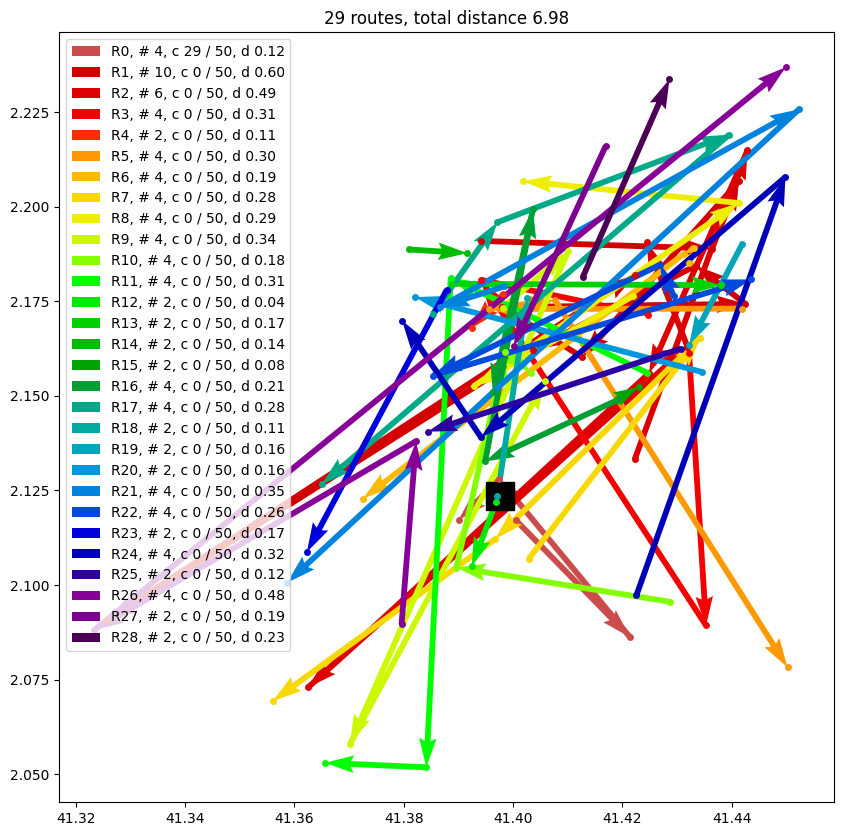

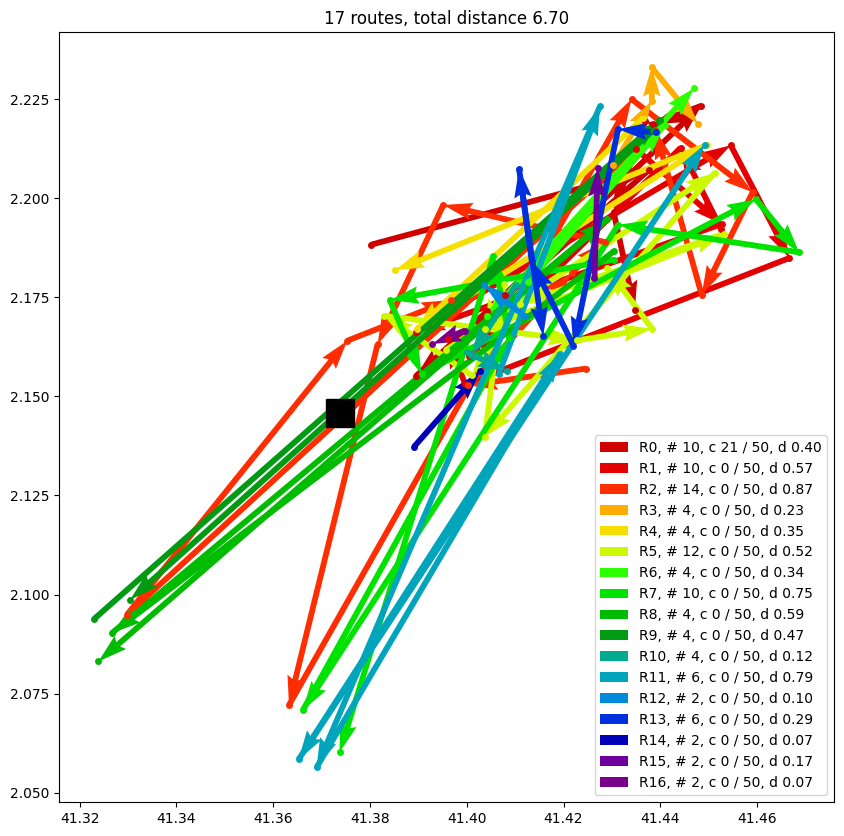

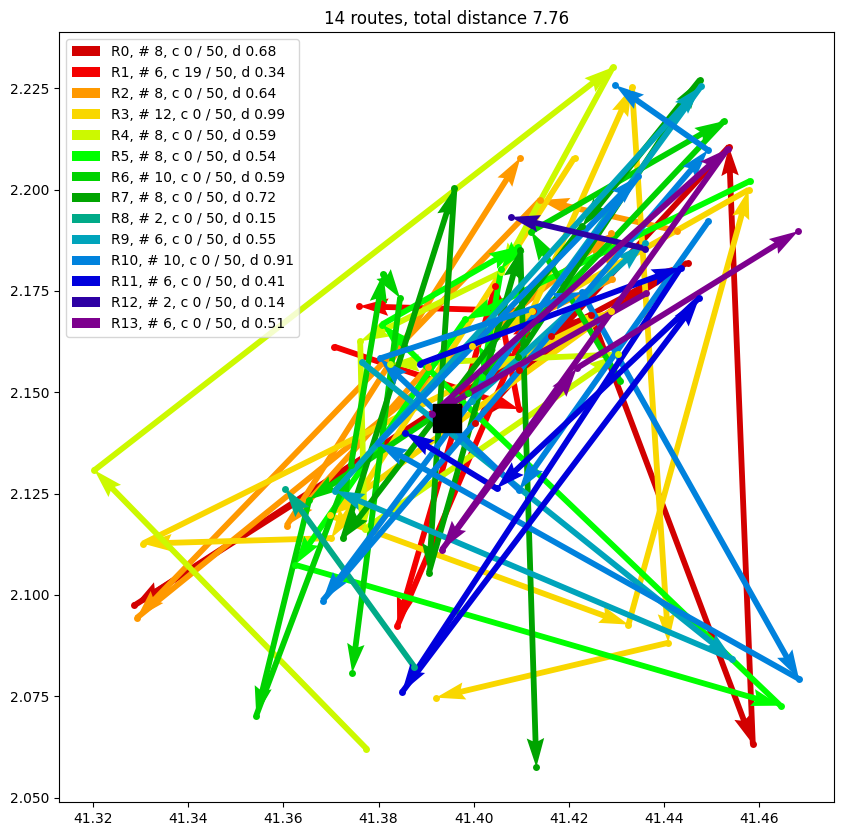

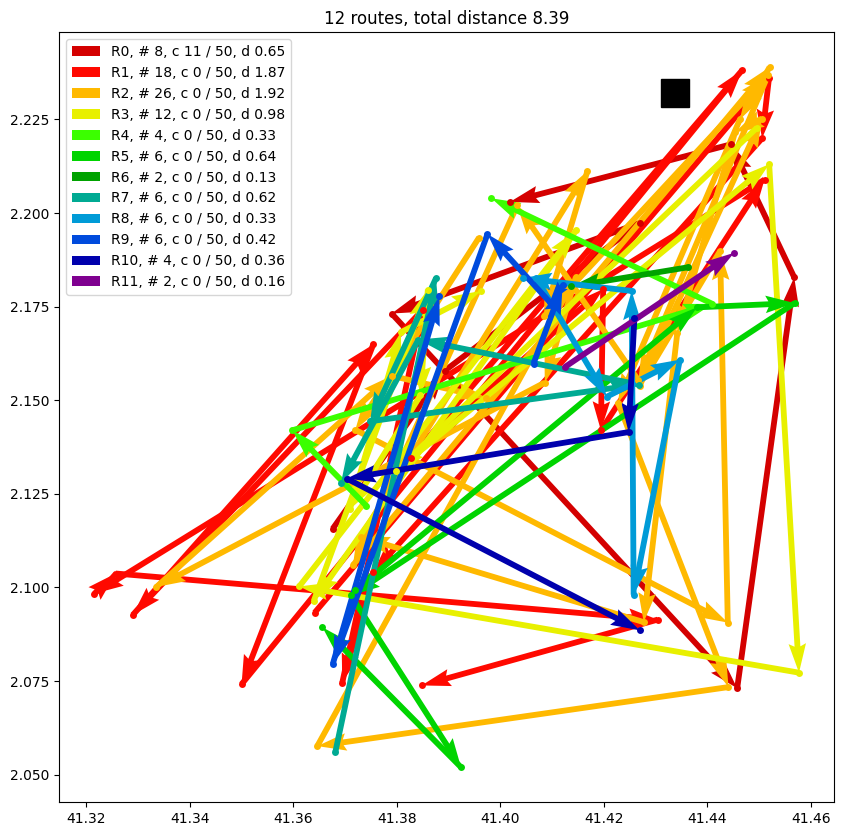

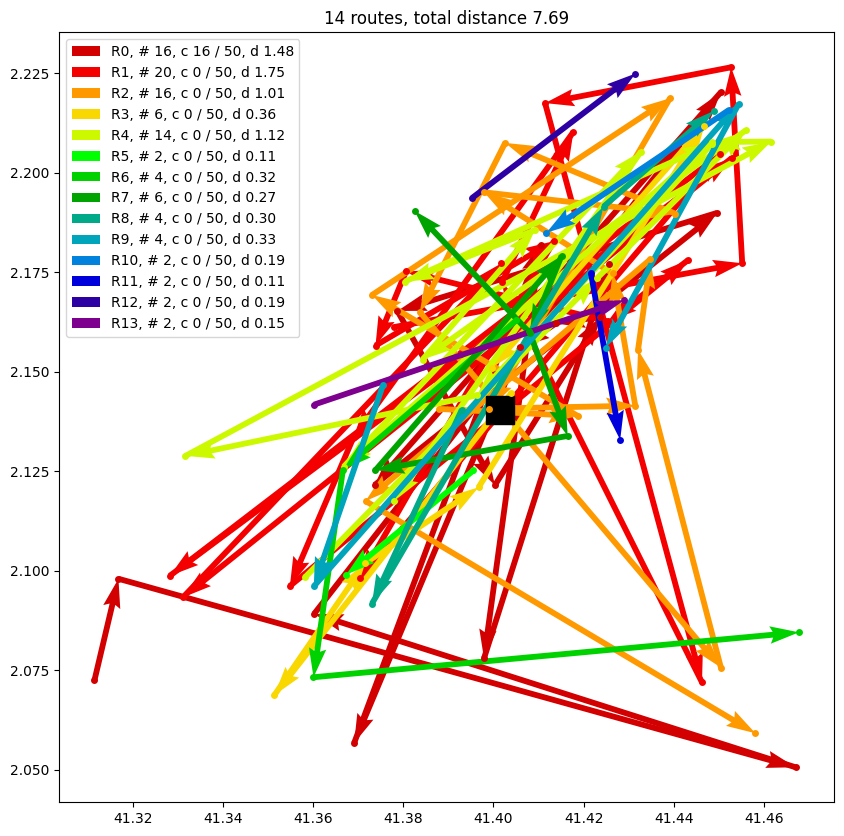

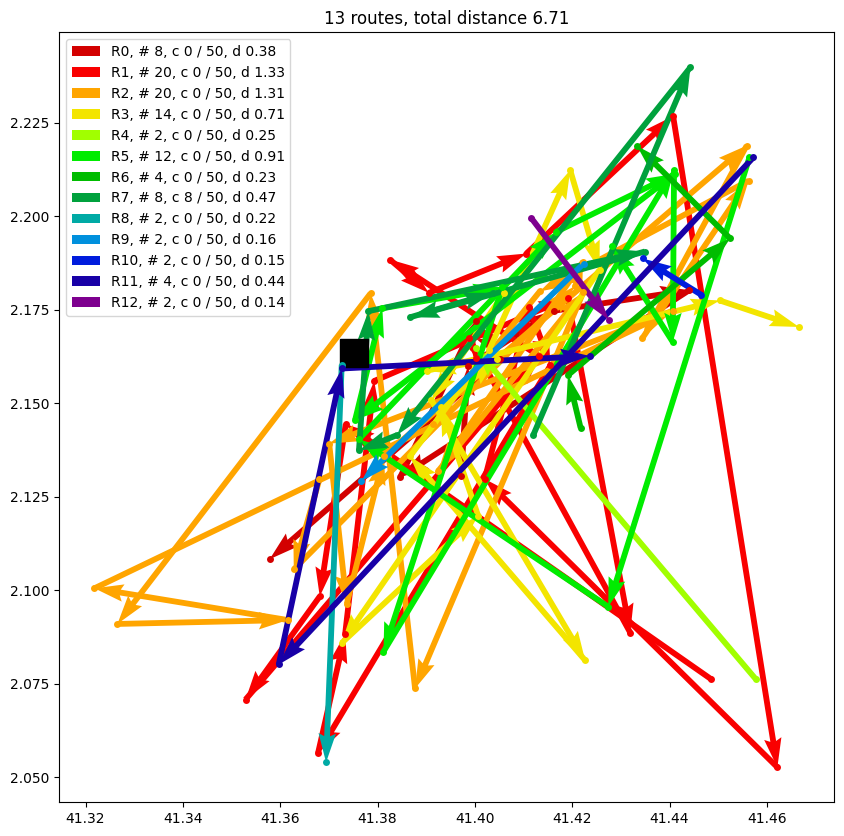

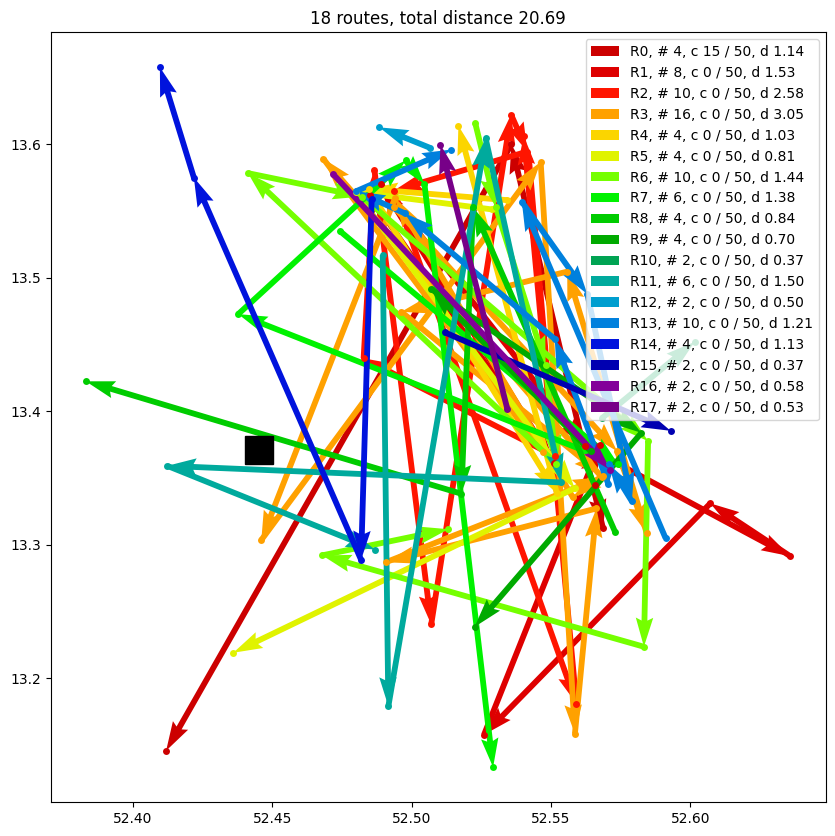

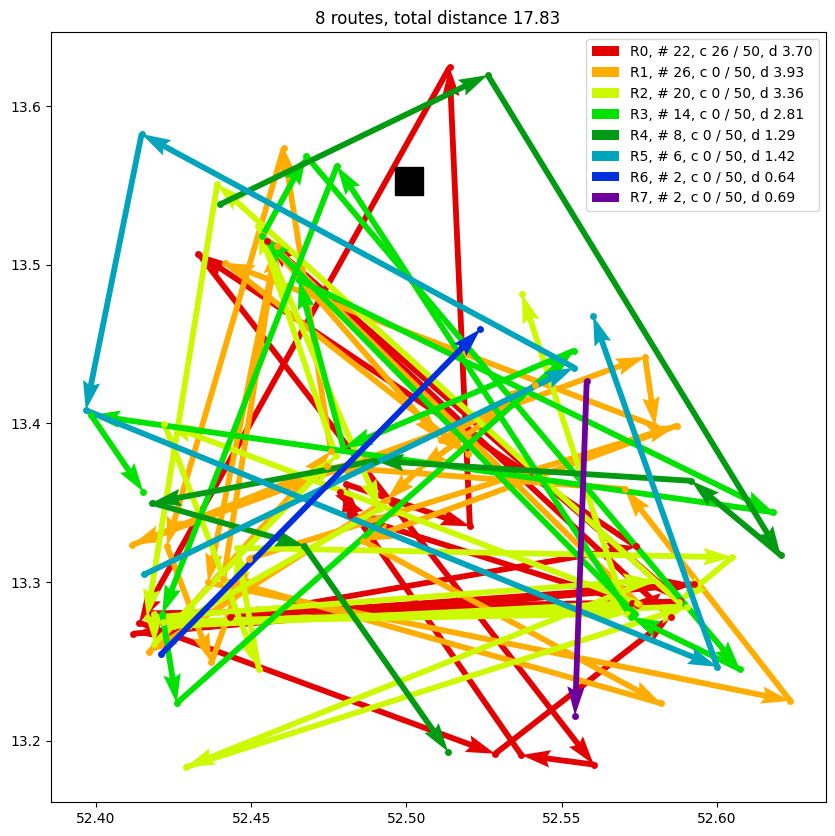

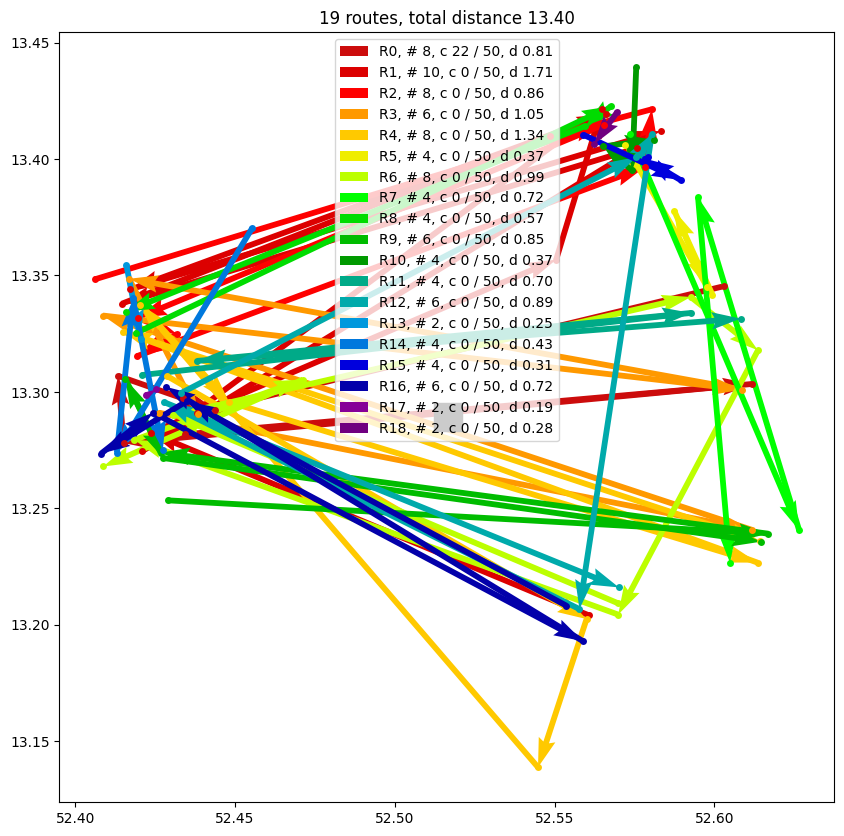

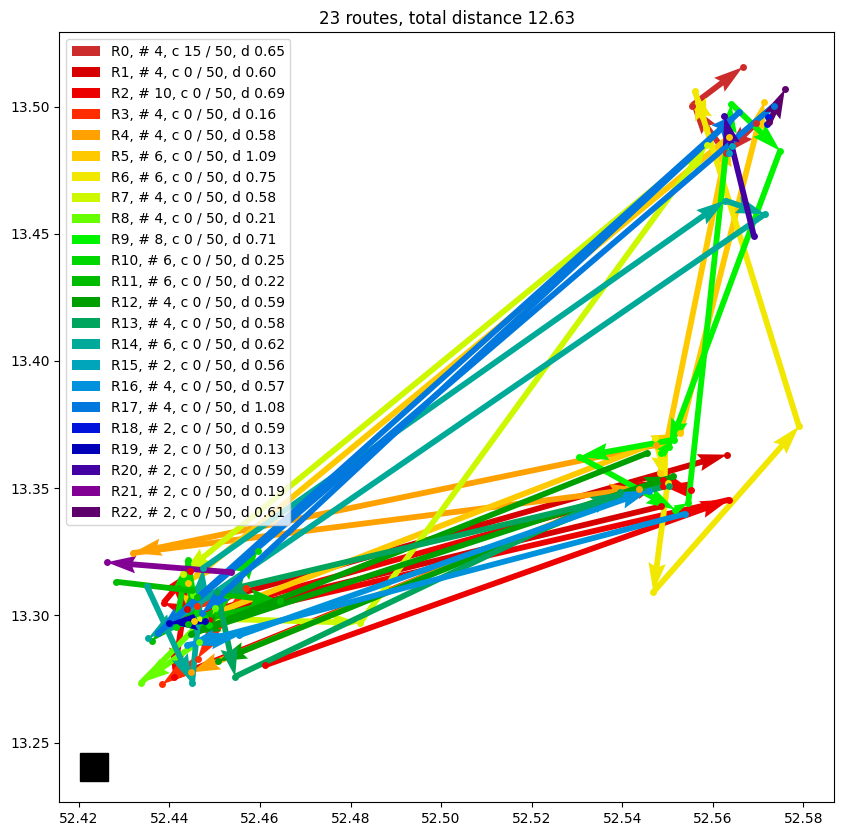

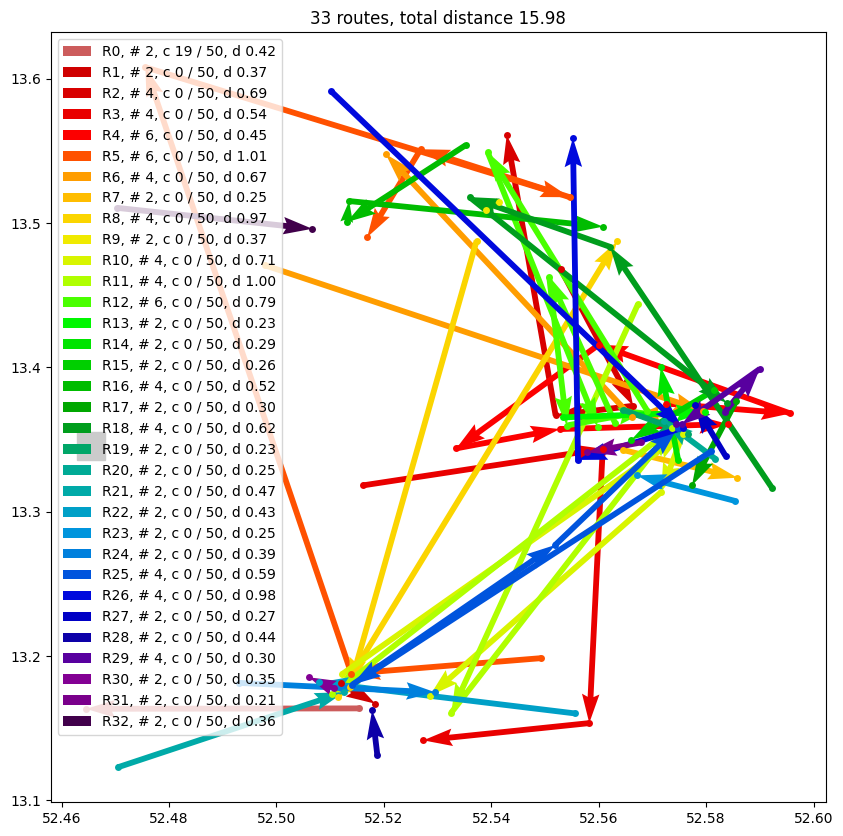

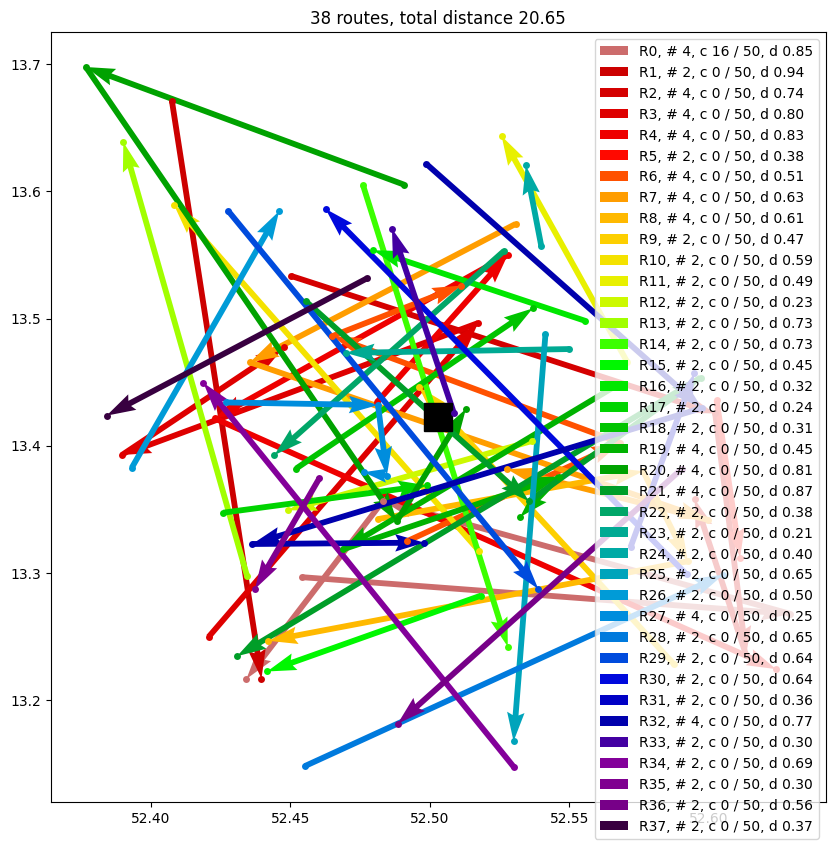

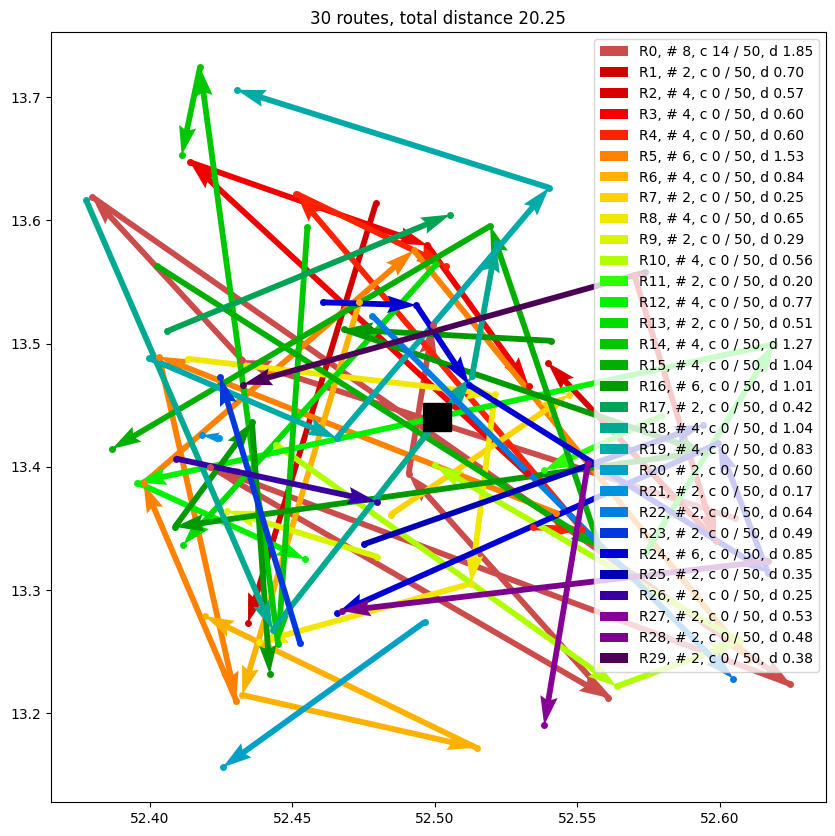

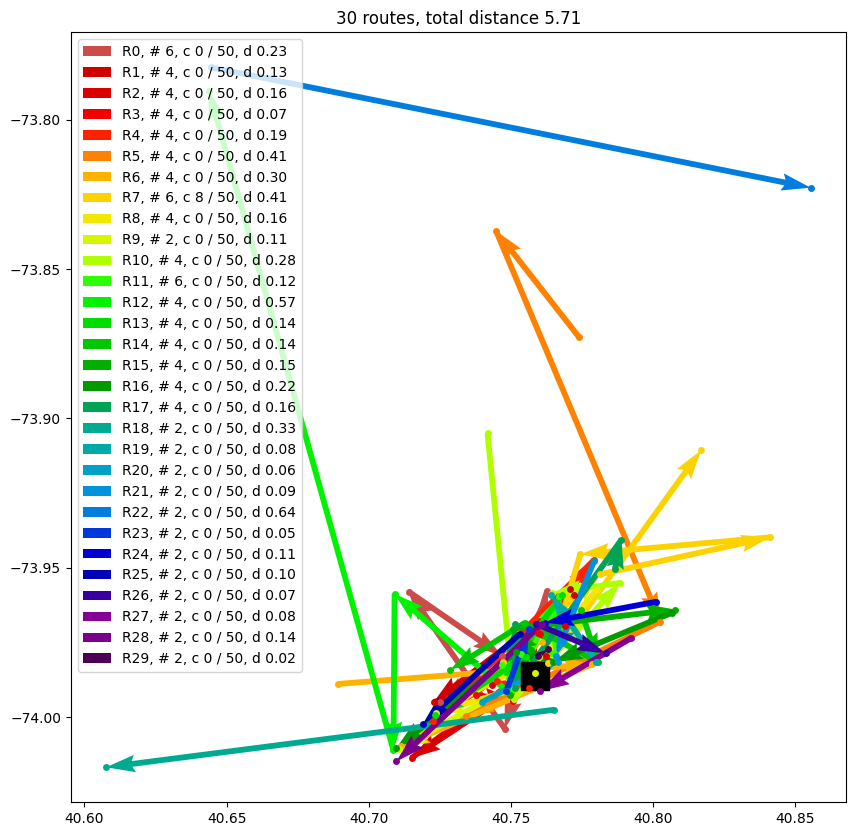

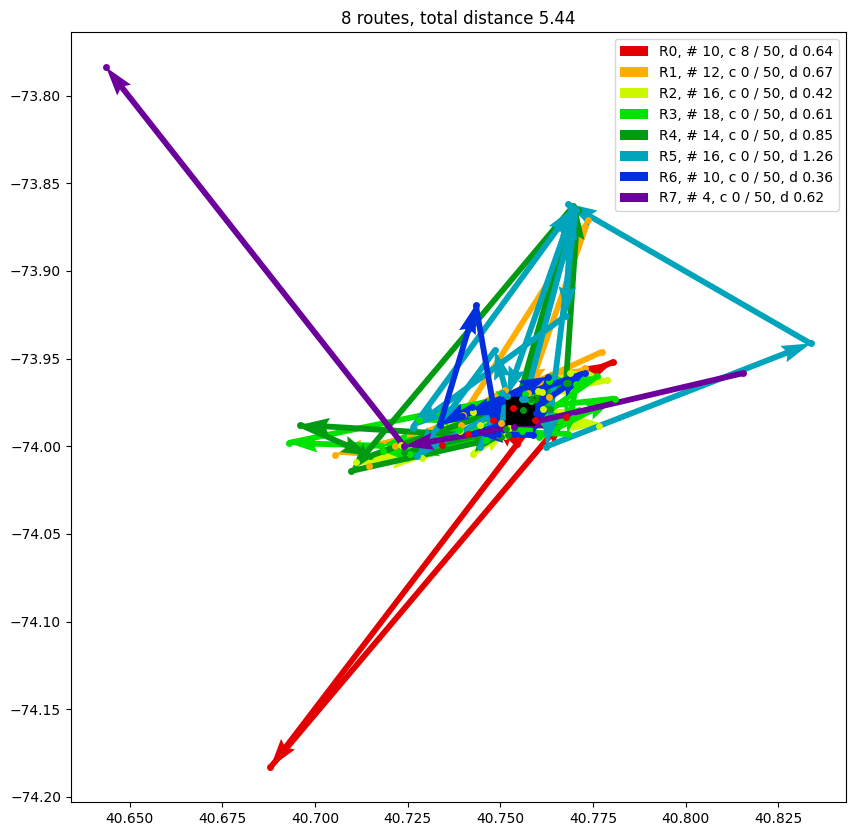

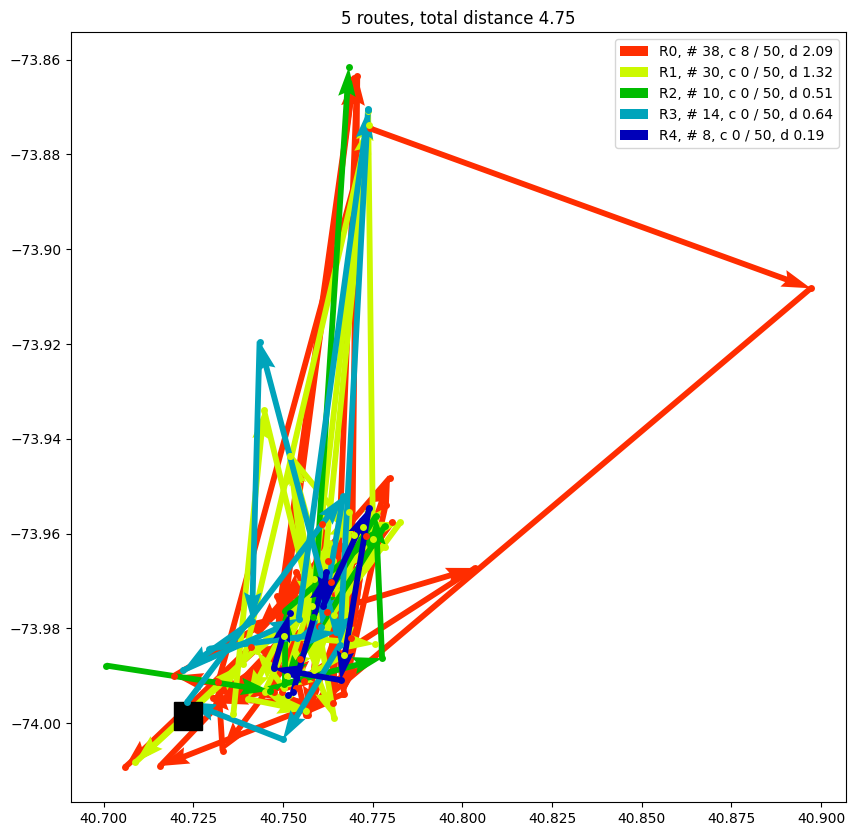

In [293]:
# Plot the results
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [290]:
tours

tensor([[ 1,  3, 51,  ...,  0,  0,  0],
        [ 6, 10, 56,  ...,  0,  0,  0],
        [ 5,  2, 10,  ...,  0,  0,  0],
        ...,
        [11, 33, 61,  ...,  0,  0,  0],
        [11,  1,  3,  ...,  0,  0,  0],
        [ 3,  5, 15,  ...,  0,  0,  0]])

In [ ]:
class StateCVRP(NamedTuple):
    # Fixed input
    coords: torch.Tensor  # Depot + loc
    demand: torch.Tensor

    # If this state contains multiple copies (i.e. beam search) for the same instance, then for memory efficiency
    # the coords and demands tensors are not kept multiple times, so we need to use the ids to index the correct rows.
    ids: torch.Tensor  # Keeps track of original fixed data index of rows

    # State
    prev_a: torch.Tensor
    used_capacity: torch.Tensor
    visited_: torch.Tensor  # Keeps track of nodes that have been visited
    lengths: torch.Tensor
    cur_coord: torch.Tensor
    i: torch.Tensor  # Keeps track of step

    VEHICLE_CAPACITY = 1.0  # Hardcoded

    @property
    def visited(self):
        if self.visited_.dtype == torch.uint8:
            return self.visited_
        else:
            return mask_long2bool(self.visited_, n=self.demand.size(-1))

    @property
    def dist(self):
        return (self.coords[:, :, None, :] - self.coords[:, None, :, :]).norm(p=2, dim=-1)

    def __getitem__(self, key):
        assert torch.is_tensor(key) or isinstance(key, slice)  # If tensor, idx all tensors by this tensor:
        return self._replace(
            ids=self.ids[key],
            prev_a=self.prev_a[key],
            used_capacity=self.used_capacity[key],
            visited_=self.visited_[key],
            lengths=self.lengths[key],
            cur_coord=self.cur_coord[key],
        )

    # Warning: cannot override len of NamedTuple, len should be number of fields, not batch size
    # def __len__(self):
    #     return len(self.used_capacity)

    @staticmethod
    def initialize(input, visited_dtype=torch.uint8):

        depot = input['depot']
        loc = input['loc']
        demand = input['demand']

        batch_size, n_loc, _ = loc.size()
        return StateCVRP(
            coords=torch.cat((depot[:, None, :], loc), -2),
            demand=demand,
            ids=torch.arange(batch_size, dtype=torch.int64, device=loc.device)[:, None],  # Add steps dimension
            prev_a=torch.zeros(batch_size, 1, dtype=torch.long, device=loc.device),
            used_capacity=demand.new_zeros(batch_size, 1),
            visited_=(  # Visited as mask is easier to understand, as long more memory efficient
                # Keep visited_ with depot so we can scatter efficiently
                torch.zeros(
                    batch_size, 1, n_loc + 1,
                    dtype=torch.uint8, device=loc.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_loc + 63) // 64, dtype=torch.int64, device=loc.device)  # Ceil
            ),
            lengths=torch.zeros(batch_size, 1, device=loc.device),
            cur_coord=input['depot'][:, None, :],  # Add step dimension
            i=torch.zeros(1, dtype=torch.int64, device=loc.device)  # Vector with length num_steps
        )

    def get_final_cost(self):

        assert self.all_finished()

        return self.lengths + (self.coords[self.ids, 0, :] - self.cur_coord).norm(p=2, dim=-1)

    def update(self, selected):

        assert self.i.size(0) == 1, "Can only update if state represents single step"

        # Update the state
        selected = selected[:, None]  # Add dimension for step
        prev_a = selected
        n_loc = self.demand.size(-1)  # Excludes depot

        # Add the length
        cur_coord = self.coords[self.ids, selected]
        # cur_coord = self.coords.gather(
        #     1,
        #     selected[:, None].expand(selected.size(0), 1, self.coords.size(-1))
        # )[:, 0, :]
        lengths = self.lengths + (cur_coord - self.cur_coord).norm(p=2, dim=-1)  # (batch_dim, 1)

        # Not selected_demand is demand of first node (by clamp) so incorrect for nodes that visit depot!
        #selected_demand = self.demand.gather(-1, torch.clamp(prev_a - 1, 0, n_loc - 1))
        selected_demand = self.demand[self.ids, torch.clamp(prev_a - 1, 0, n_loc - 1)]

        # Increase capacity if depot is not visited, otherwise set to 0
        #used_capacity = torch.where(selected == 0, 0, self.used_capacity + selected_demand)
        used_capacity = (self.used_capacity + selected_demand) * (prev_a != 0).float()

        if self.visited_.dtype == torch.uint8:
            # Note: here we do not subtract one as we have to scatter so the first column allows scattering depot
            # Add one dimension since we write a single value
            visited_ = self.visited_.scatter(-1, prev_a[:, :, None], 1)
        else:
            # This works, will not set anything if prev_a -1 == -1 (depot)
            visited_ = mask_long_scatter(self.visited_, prev_a - 1)

        return self._replace(
            prev_a=prev_a, used_capacity=used_capacity, visited_=visited_,
            lengths=lengths, cur_coord=cur_coord, i=self.i + 1
        )

    def all_finished(self):
        return self.i.item() >= self.demand.size(-1) and self.visited.all()

    def get_finished(self):
        return self.visited.sum(-1) == self.visited.size(-1)

    def get_current_node(self):
        return self.prev_a

    def get_mask(self):
        """
        Gets a (batch_size, n_loc + 1) mask with the feasible actions (0 = depot), depends on already visited and
        remaining capacity. 0 = feasible, 1 = infeasible
        Forbids to visit depot twice in a row, unless all nodes have been visited
        :return:
        """

        if self.visited_.dtype == torch.uint8:
            visited_loc = self.visited_[:, :, 1:]
        else:
            visited_loc = mask_long2bool(self.visited_, n=self.demand.size(-1))

        # For demand steps_dim is inserted by indexing with id, for used_capacity insert node dim for broadcasting
        exceeds_cap = (self.demand[self.ids, :] + self.used_capacity[:, :, None] > self.VEHICLE_CAPACITY)
        # Nodes that cannot be visited are already visited or too much demand to be served now
        mask_loc = visited_loc.to(exceeds_cap.dtype) | exceeds_cap
        # print(mask_loc.shape)

        # Cannot visit the depot if just visited and still unserved nodes
        mask_depot = (self.prev_a == 0) & ((mask_loc == 0).int().sum(-1) > 0)
        # print((self.prev_a==0),((mask_loc == 0).int().sum(-1)>0))
        return torch.cat((mask_depot[:, :, None], mask_loc), -1)

    def construct_solutions(self, actions):
        return actions

In [ ]:
#Generate sample usage
CAPACITIES = {
                10: 20.,
                20: 30.,
                50: 40.,
                100: 50.
            }
size = 20
num_samples = 2

data = {
        'loc': torch.FloatTensor(num_samples, size, 2).uniform_(0, 1),
        # Uniform 1 - 9, scaled by capacities
        'demand': (torch.FloatTensor(num_samples, size).uniform_(0, 9).int() + 1).float() / CAPACITIES[size],
        'depot': torch.FloatTensor(num_samples, 2).uniform_(0, 1)
    }

In [45]:
state = StateCVRP.initialize(data)
# state = state.update(selected=torch.tensor([3, 1]))
# state = state.update(selected=torch.tensor([5, 3]))
# state = state.update(selected=torch.tensor([0, 2]))
state.get_mask().shape

torch.Size([2, 1, 21])

In [46]:
#Simulate environment

B = 2
N = 21
step = 0
all_actions = []         # to store actions at each step
all_used_capacity = []   # optional

while not state.all_finished():
    # STEP 1: Random logits for actions (could come from a model)
    logits = torch.randn(B, N)

    mask = state.get_mask().squeeze(1)

    # STEP 2: Apply mask → invalid actions should never be selected
    masked_logits = logits.masked_fill(mask, float('-inf'))

    # STEP 3: Sample action using Categorical distribution
    dist = torch.distributions.Categorical(logits=masked_logits)
    actions = dist.sample()  # shape: (B,), each in [0, N-1]

    # STEP 4: Update environment — you define this logic
    # Example: increase state by action ID
    state = state.update(selected=actions)

    step += 1

    all_actions.append(actions)
    all_used_capacity.append(state.used_capacity.squeeze(1).tolist())

    print(f"Step {step}, Actions: {actions}, Used Capacity: {state.used_capacity.squeeze(1).tolist()}")

Step 1, Actions: tensor([ 6, 12]), Used Capacity: [0.30000001192092896, 0.13333334028720856]
Step 2, Actions: tensor([5, 9]), Used Capacity: [0.6000000238418579, 0.3333333432674408]
Step 3, Actions: tensor([3, 0]), Used Capacity: [0.800000011920929, 0.0]
Step 4, Actions: tensor([8, 1]), Used Capacity: [0.8333333730697632, 0.30000001192092896]
Step 5, Actions: tensor([15,  6]), Used Capacity: [0.8666667342185974, 0.36666667461395264]
Step 6, Actions: tensor([0, 7]), Used Capacity: [0.0, 0.6666666865348816]
Step 7, Actions: tensor([ 1, 19]), Used Capacity: [0.30000001192092896, 0.7000000476837158]
Step 8, Actions: tensor([14, 17]), Used Capacity: [0.4333333373069763, 0.73333340883255]
Step 9, Actions: tensor([16, 13]), Used Capacity: [0.5, 0.9000000953674316]
Step 10, Actions: tensor([10,  0]), Used Capacity: [0.7666666507720947, 0.0]
Step 11, Actions: tensor([0, 2]), Used Capacity: [0.0, 0.30000001192092896]
Step 12, Actions: tensor([12, 16]), Used Capacity: [0.20000000298023224, 0.5]
S

In [47]:
state

StateCVRP(coords=tensor([[[0.9359, 0.8094],
         [0.3842, 0.9583],
         [0.0892, 0.4242],
         [0.1374, 0.0858],
         [0.5848, 0.5434],
         [0.8646, 0.2474],
         [0.2220, 0.0850],
         [0.7090, 0.1951],
         [0.0187, 0.9646],
         [0.0357, 0.7732],
         [0.0245, 0.8721],
         [0.0467, 0.1822],
         [0.4289, 0.7181],
         [0.5766, 0.0239],
         [0.3267, 0.2894],
         [0.7753, 0.0683],
         [0.3620, 0.5189],
         [0.4260, 0.5312],
         [0.1635, 0.0479],
         [0.8702, 0.1300],
         [0.7979, 0.8993]],

        [[0.0892, 0.4157],
         [0.0515, 0.1085],
         [0.1209, 0.7558],
         [0.9405, 0.1585],
         [0.1589, 0.8651],
         [0.3682, 0.9875],
         [0.3204, 0.5968],
         [0.4885, 0.7541],
         [0.5534, 0.1837],
         [0.9547, 0.7369],
         [0.4706, 0.6497],
         [0.9392, 0.1252],
         [0.9775, 0.8978],
         [0.5726, 0.8046],
         [0.2181, 0.8927],
         